## Introduction

Libraries Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Read images
from matplotlib import image

# Customs matplotlib colors
from matplotlib import colors

# Read files from a directory
import glob

# Prints a neat progress bar
from tqdm.notebook import trange, tqdm

# Retina (high pixel density) plot display
%config InlineBackend.figure_format = 'retina'

Images Import

In [2]:
# Load the images from the directory and normalize them
images = []
for filename in glob.glob('images/*.jpg'):
    images.append(np.asarray(image.imread(filename)) / 255)

Plotting Utilities

In [3]:
def rgb2gray(rgb):
    """
    Convert an RGB image to grayscale approximating human eye perception of colors
    """
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [4]:
def plot_motion_vectors(motion_vectors, img1, offset=0.5, density=1, scale=1):
    """
    Plot a vector field in a matrix grid each step pixels
    """
    fig, ax = plt.subplots(figsize=((max(img1.shape[1] // 20, 10), \
                                     max(img1.shape[0] // 20, 10))))
    
    # Compute the step to take to get the desired density of vectors per pixel
    vec_density = (motion_vectors.shape[0] / images[0].shape[0]) * 25
    step = int(max(np.ceil(vec_density / density), 1))

    U, V = np.array(motion_vectors[::step, ::step, 0]).astype(float), \
        np.array(motion_vectors[::step, ::step, 1]).astype(float)
    X, Y = np.array(motion_vectors[::step, ::step, 2]).astype(float) \
        + offset, np.array(motion_vectors[::step, ::step, 3]).astype(float) + offset

    angle = np.arctan2(U, V)

    # Plot the grid
    ax.imshow(rgb2gray(img1), cmap='gray')

    # Draw the vectors from (Xi, Yi) to (Ui, Vi)
    # Their color is a lerp according to the angle
    # Their norm needs to be greater than 0 to be drawn
    ax.quiver(Y, X, V, U, angle, angles='xy', scale_units='xy', pivot="tail", \
              scale=1/scale, color='r', minshaft = 1, minlength=0)

    # Show the result
    plt.show()

In [5]:
def plot_images_motion_vectors(motion_vectors, img_size):
    """
    Plot the motion vectors in 3 different images (X, Y, norm)
    """
    # Split vectors components into X and Y lists
    X, Y = motion_vectors[:, :, 0], motion_vectors[:, :, 1]
    # Calculate their norm
    N = np.sqrt(X ** 2 + Y ** 2)
    A = np.arctan2(X, Y)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=((max(img_size[1] // 20, 10), max(img_size[0] // 20, 10))))

    # Custom lerp color map
    cmap_n = colors.LinearSegmentedColormap.from_list('mycmap2', ['white', 'black'])

    cmin, cmax = -np.pi, np.pi
    # Plot the images
    im1 = ax1.imshow(A, vmin=cmin, vmax=cmax)
    cb = fig.colorbar(im1, ax=ax1, label="Angle")
    cb.set_ticks(np.linspace(cmin, cmax, 5))
    cb.set_ticklabels( \
        ['-π (left)', '-π/2 (top)', '0 (right or zero vector)', 'π/2 (bottom)', 'π (left)'])

    im2 = ax2.imshow(N, cmap=cmap_n)
    fig.colorbar(im2, ax=ax2, label="Norm", cmap=cmap_n)

    # Show the result
    plt.show()

## Implementations

### (A) PMA (Pixel Matching Algorithm)

Implementation

In [6]:
def pma(frame1, frame2, search_range):
    """
    Calculate the motion vector matrix using the PMA algorithm
    """
    # Gray the frames to get intensity images (human eye gray)
    frame1 = rgb2gray(frame1)
    frame2 = rgb2gray(frame2)
    
    # Calculate the dimensions of the frames (constant for all frames)
    height, width = frame1.shape
    
    # Initialize the output vector field to zeros
    vector_field = np.empty((height, width, 4))
    
    # Loop over each pixel in frame 1
    for i in trange(height):
        for j in range(width):
            
            # Extract the current intensity pixel (IP) from frame 1
            current_pixel = frame1[i, j]
            
            # Initialize the minimum error and minimum distance vector
            min_error = np.inf
            min_distance = np.inf
            min_error_vector = None
            
            # Loop over the search range (block_range in this case) in frame 2
            for m in range(-search_range, search_range+1):
                for n in range(-search_range, search_range+1):
                    # Calculate the index of the search IP in frame 2
                    search_i = i + m
                    search_j = j + n
                    
                    # Check that the search IP is within the bounds of the frame
                    if (search_i < 0 or search_i >= height or 
                        search_j < 0 or search_j >= width):
                        continue
                        
                    # Extract the search IP from frame 2
                    search_pixel = frame2[search_i, search_j]
                    
                    # Calculate the absolute error between the current IP and the search IP
                    error = np.abs(current_pixel - search_pixel)
                    
                    # Calculate the squared distance between them
                    distance = m ** 2 + n ** 2
                    
                    # If the error is lower than the current minimum, update the minimum
                    # error and distance
                    # If the error is equal to the current minimum, choose the minimum
                    # distance
                    if error < min_error or (error == min_error and distance < min_distance):
                        min_error = error
                        min_distance = distance
                        min_error_vector = np.array([m, n, i, j])
            
            # Set the vector field at the current pixel coordinates to the minimum error and
            # distance vector found
            vector_field[i, j] = min_error_vector
    
    # Return the vector field
    return vector_field

Example on two simple matrices with a simple movement

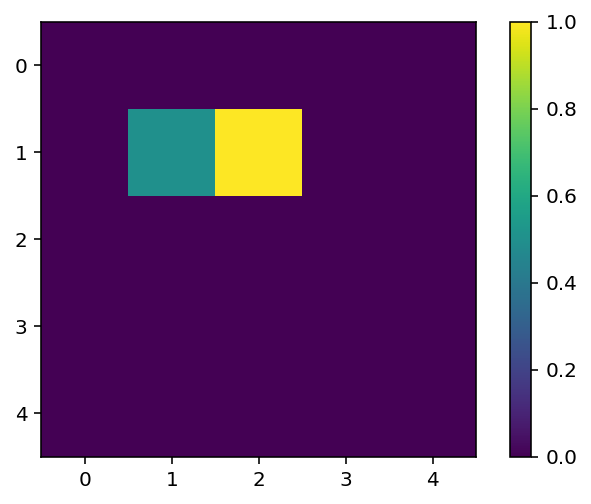

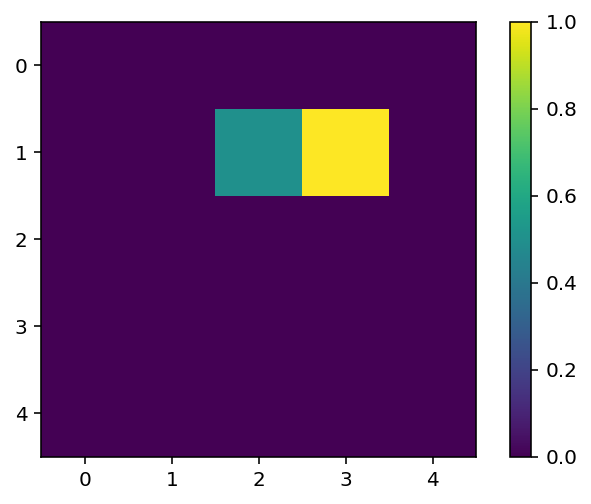

In [7]:
# Right movement of two pixels across a 5x5 image
A = np.full((5, 5, 3), [0, 0, 0], dtype=np.float32)
A[(1, 1)] = [0.5, 0.5, 0.5]
A[(1, 2)] = [1, 1, 1]

B = np.full((5, 5, 3), [0, 0, 0], dtype=np.float32)
B[(1, 1)] = [0, 0, 0]
B[(1, 2)] = [0, 0, 0]
B[(1, 2)] = [0.5, 0.5, 0.5]
B[(1, 3)] = [1, 1, 1]

plt.imshow(np.mean(A, axis=2))
plt.colorbar()
plt.show()

plt.imshow(np.mean(B, axis=2))
plt.colorbar()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

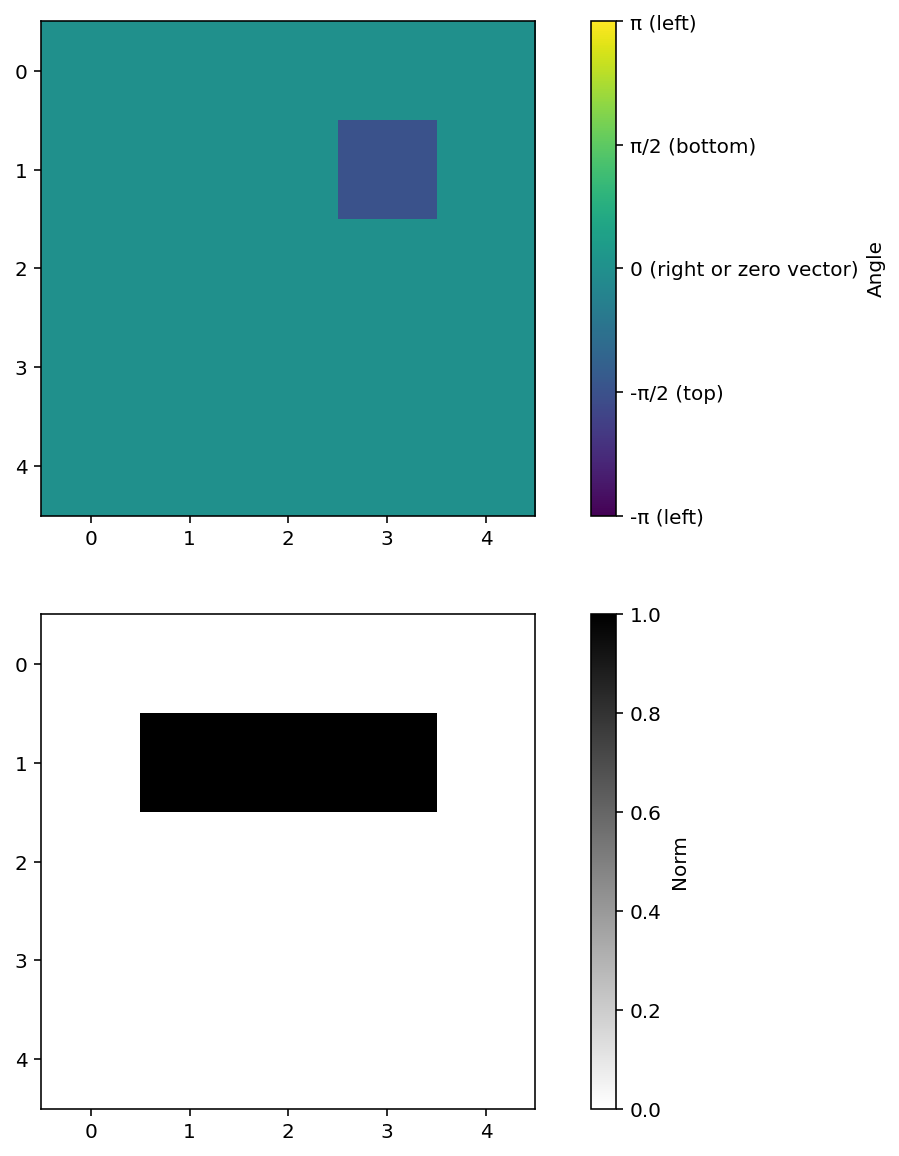

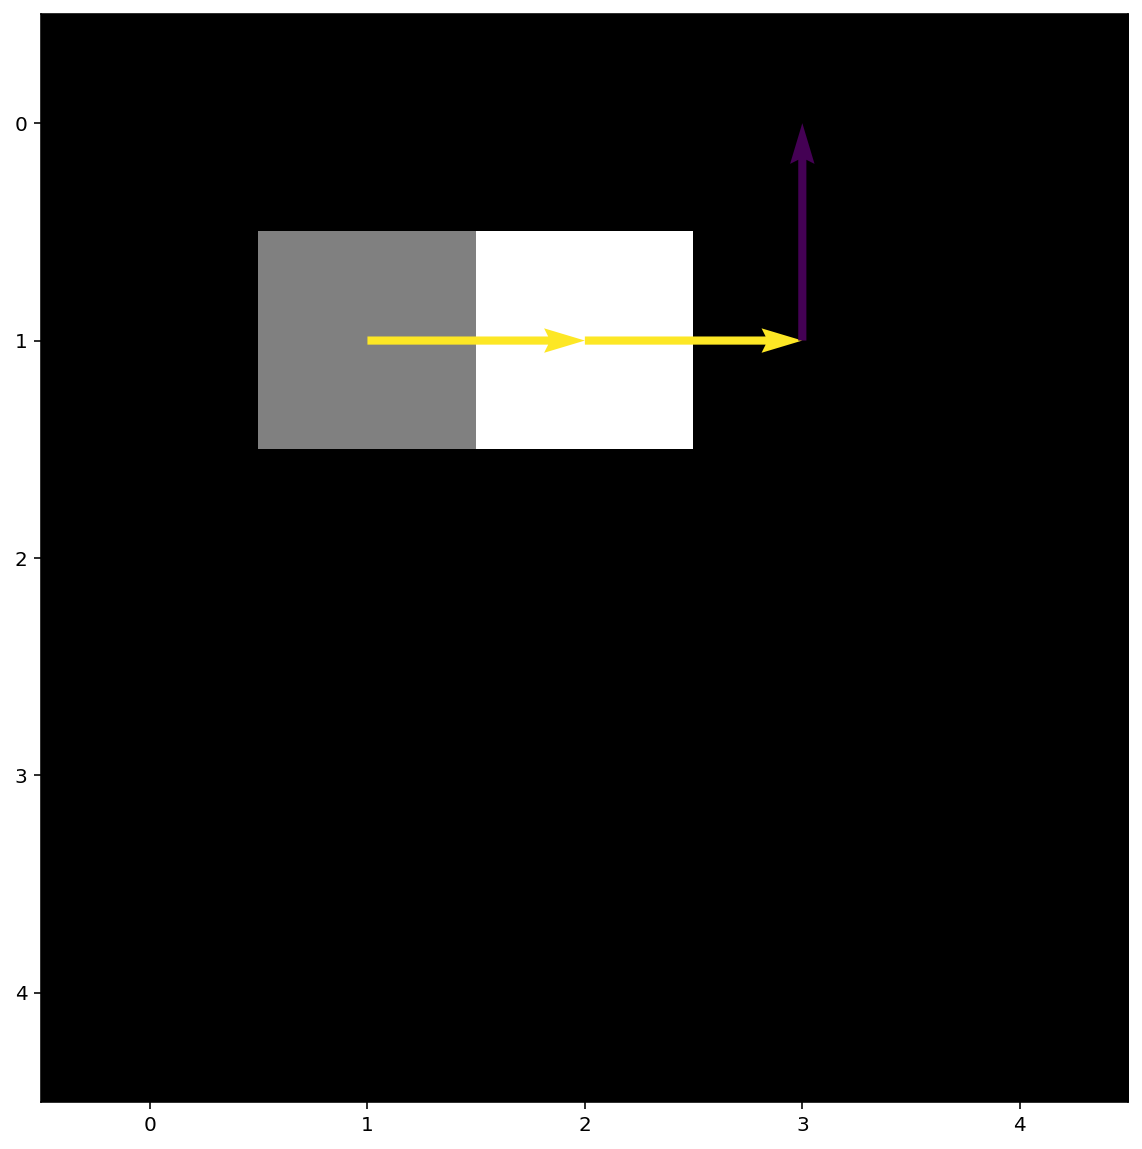

In [8]:
mvt = pma(A, B, search_range=1)
plot_images_motion_vectors(mvt, A.shape)
plot_motion_vectors(mvt, A, 0, 1)

The purple arrow is arbitrary since the pixel can be any of the 3 neighbors around that black pixel.

Processing of the movement on the first two frames using PMA (Pixel Matching Algorithm) with 5 pixel range (10x10)

  0%|          | 0/320 [00:00<?, ?it/s]

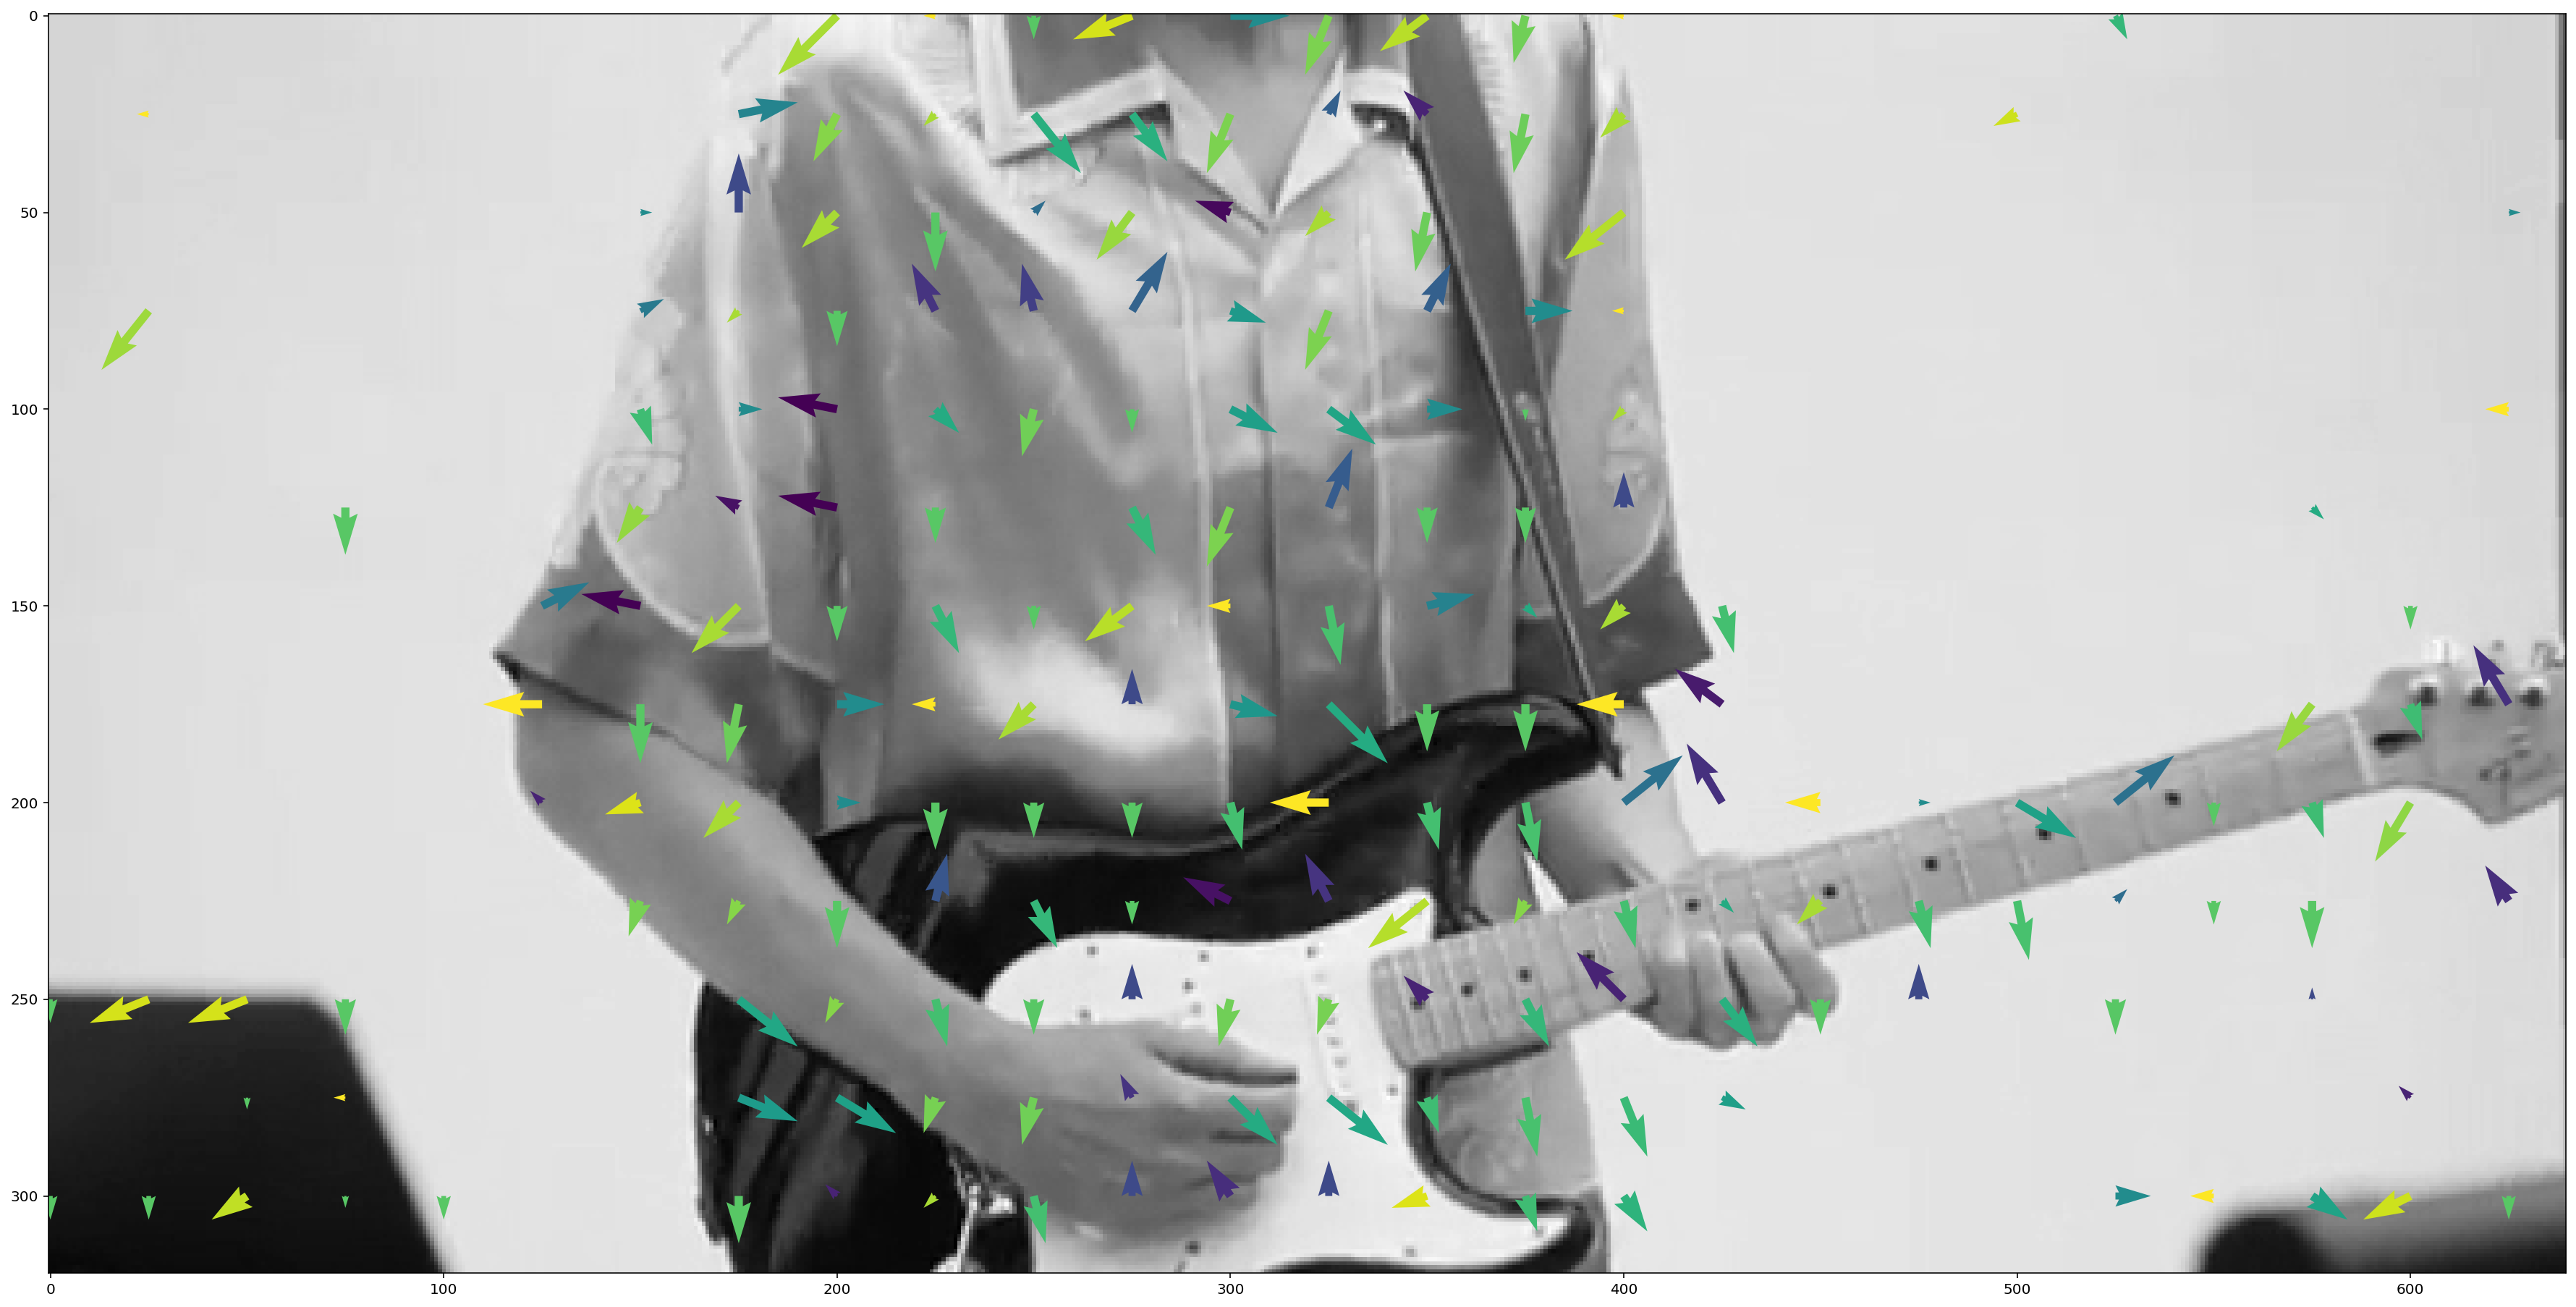

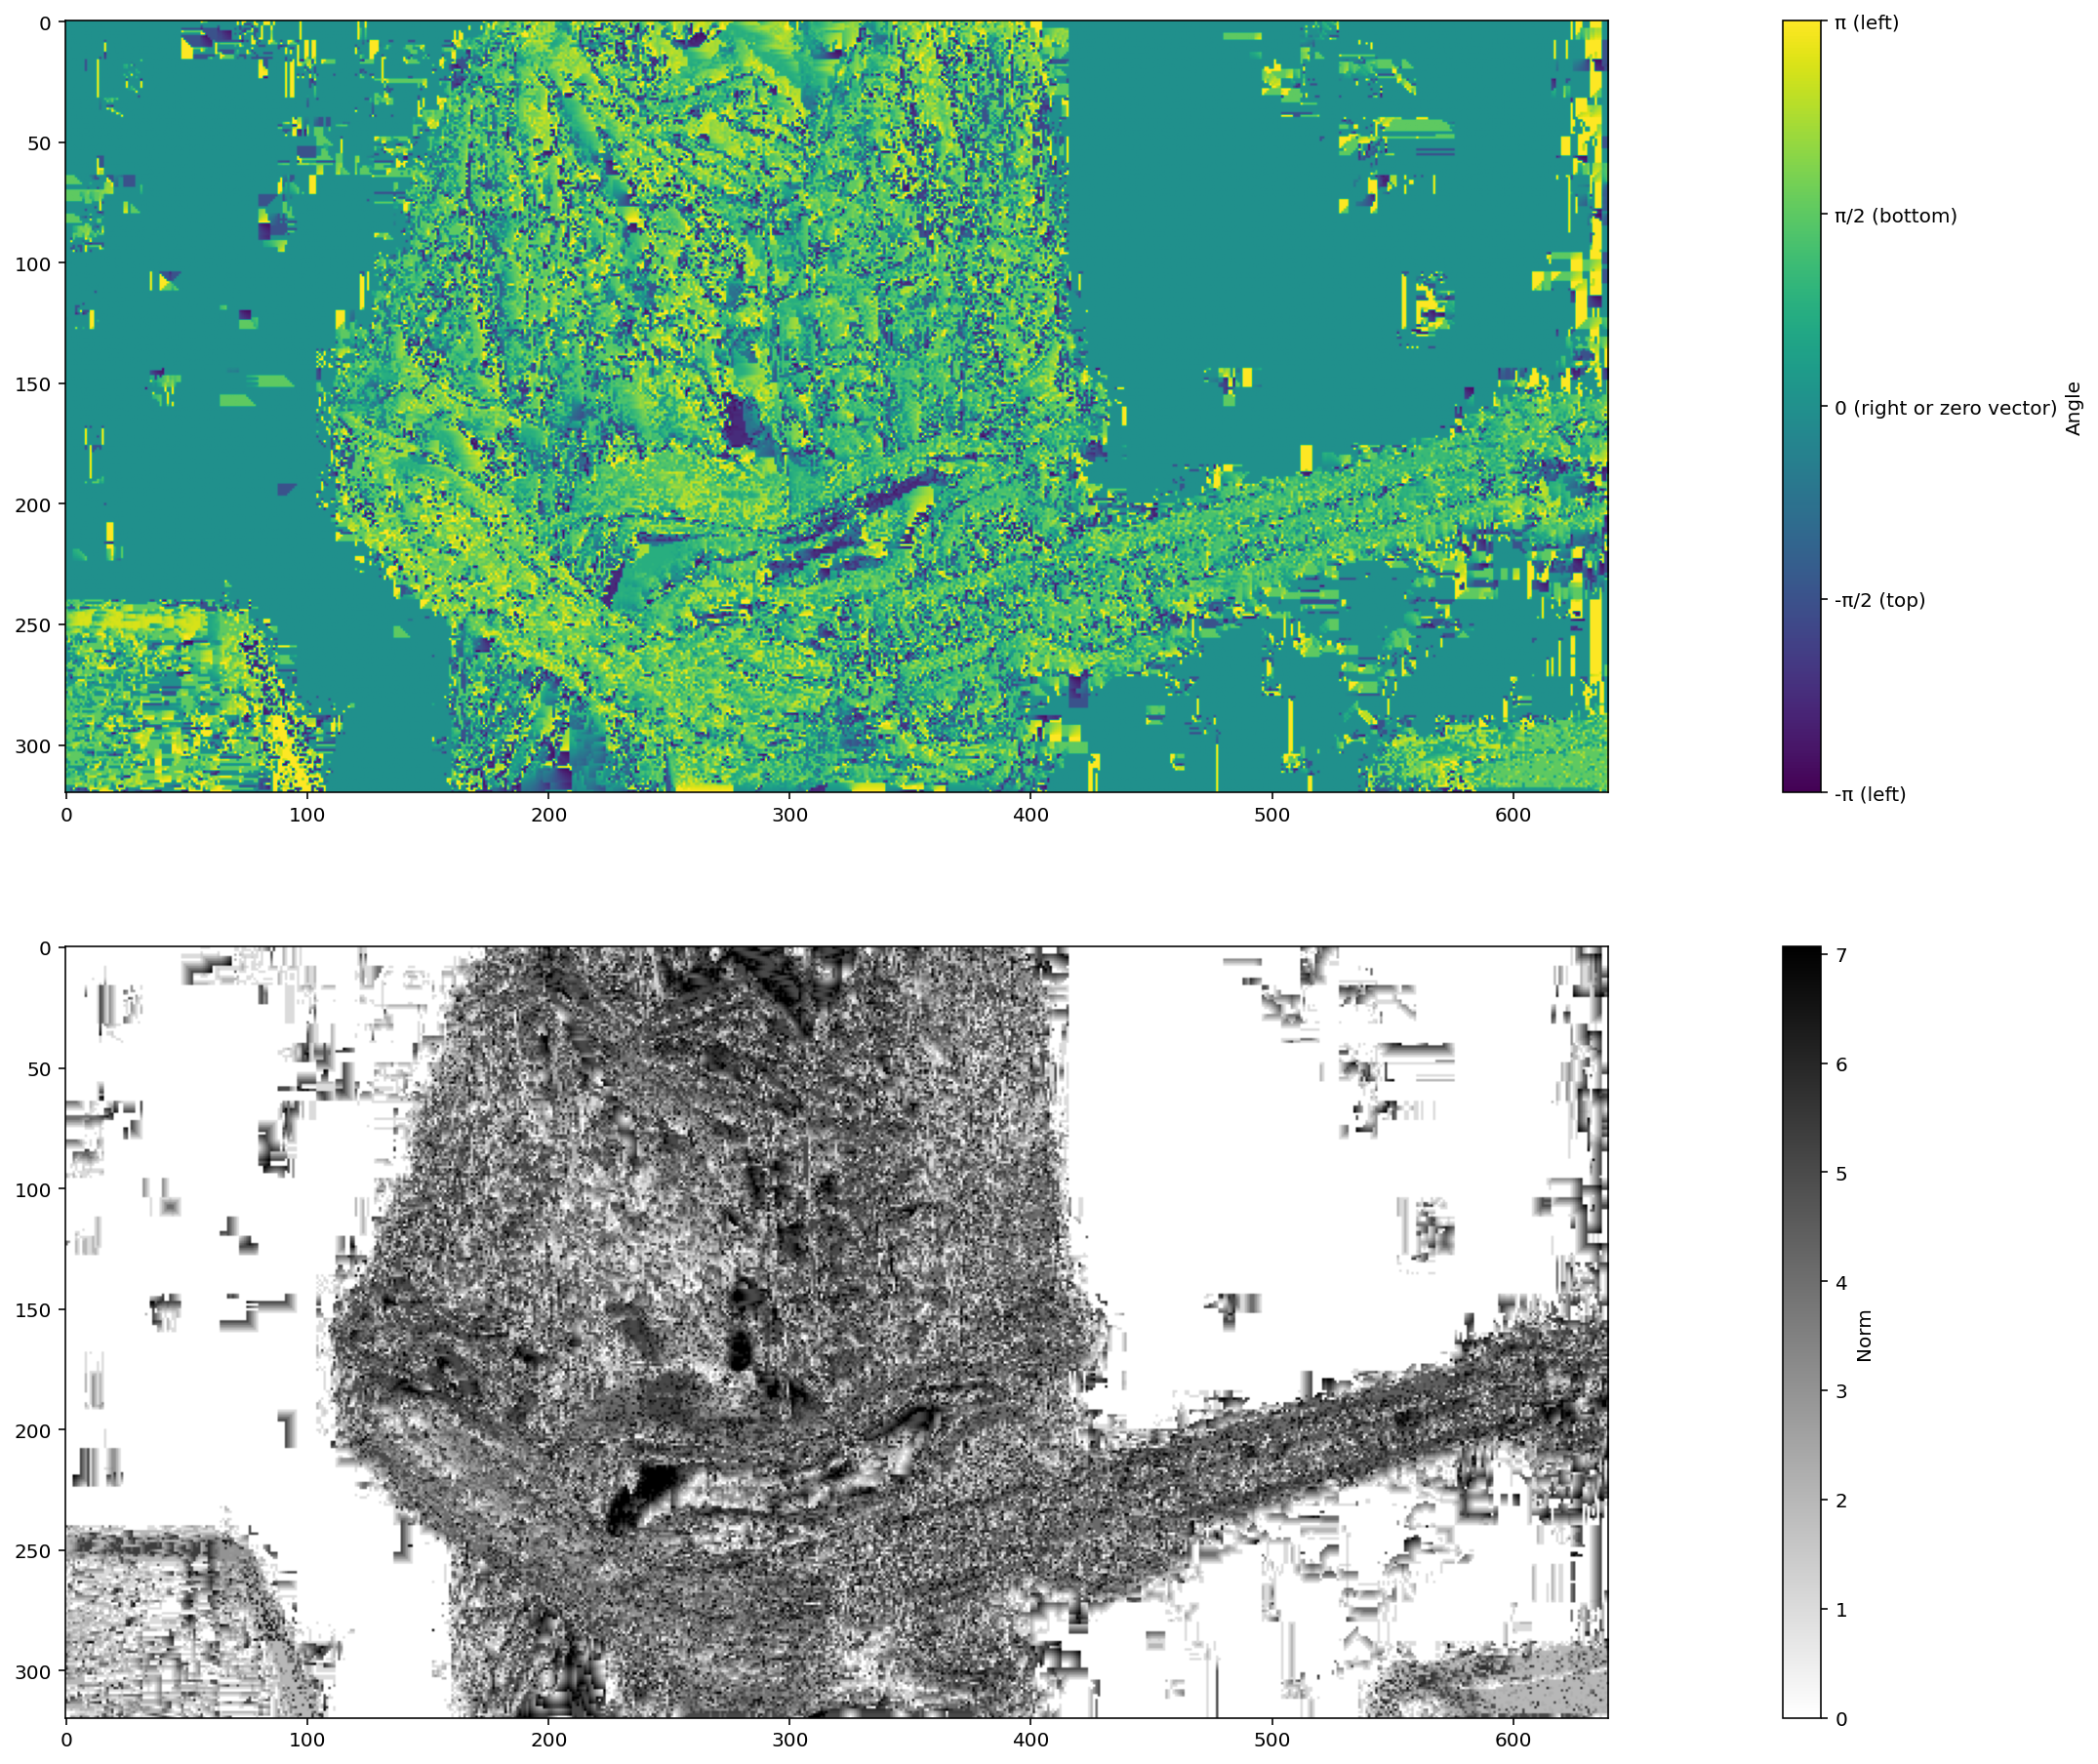

In [9]:
vectors = pma(images[0], images[1], 5)
# scaled up the vectors by 3 to be able to see them easily
plot_motion_vectors(vectors, images[0], 0, 1, 3)
plot_images_motion_vectors(vectors, images[0].shape)

It's very noisy, but it can easily distinguish the movement of the object (or person) from the background.

### (B) BMA (Block Matching Algorithm)

Implementation

In [10]:
def bma_block(frame1, frame2, block_size, search_range):
    """
    Calculate the motion vector matrix using the BMA algorithm
    """

    # Gray the frames to get intensity images (human eye gray)
    frame1 = rgb2gray(frame1)
    frame2 = rgb2gray(frame2)

    # Ignore borders of the image to avoid border cases
    # Possible improvement : pad with zeros instead
    hpad = block_size // 2 + search_range
    wpad = block_size // 2 + search_range

    # Calculate blocs per image size (constant across all frames)
    height, width = frame1.shape
    b_height, b_width = np.array(frame1.shape) // block_size

    # Vector field matrix
    vector_field = np.empty((b_height, b_width, 4), dtype=np.float32)

    # Iterate over each IP in the current frame
    for a in trange(b_height):
        for b in range(b_width):
            # Extract the current block (block around the center IP (i, j)) and avoid corners
            i, j = a * block_size, b * block_size
            current_block = frame1[i+hpad:i+hpad+block_size, j+wpad:j+wpad+block_size]

            # Initialize the error and motion vector for the window sliding block
            best_error = np.inf
            best_motion = None
            best_distance = np.inf

            # Iterate over each pixel in the search range (sliding window)
            # Max and min assure not to slide outside the image ranges
            for k in range(max(i-search_range, 0), min(i+search_range, height-block_size)):
                for l in range(max(j-search_range, 0), min(j+search_range, width-block_size)):
                    # Extract the window block from frame2
                    window_block = frame2[k+hpad:k+hpad+block_size, l+wpad:l+wpad+block_size]

                    # Calculate the mean absolute error between the current block (in frame 1)
                    # and the search block (sliding window block in frame 2) (power 1) (DFD)
                    try:
                        dfd = np.sum(np.abs(current_block - window_block))
                    except:
                        continue
                    error = dfd

                    # Calculate the euclidian distance between the current IP and the search IP
                    # In order to prioritize the closest IP if the error is equal
                    distance =  (k - i) ** 2 + (l - j) ** 2

                    # (If the current error is lower update the best error
                    # or if the current error is equal but the distance lower) then
                    # update the motion vector
                    if error < best_error or (error == best_error and distance < best_distance):	
                        best_error = error
                        best_distance = distance
                        best_motion = np.array([k-i, l-j, i, j], dtype=np.float32)

            # Store the best motion vector for the current IP (at the center of the block)
            # in the vector field
            vector_field[a, b] = best_motion

    return vector_field

In [11]:
def bma_imgs(i, j, block_size, search_range):
    vectors = bma_block(images[i], images[j], block_size, search_range)
    
    # scaled up the vectors by 3 to be able to see them easily
    plot_motion_vectors(vectors, images[i], block_size * 2, 1, 3)
    plot_images_motion_vectors(vectors, images[i].shape)

Processing of the movement on the first two frames for a block_size of 5 and a range of 10

  0%|          | 0/64 [00:00<?, ?it/s]

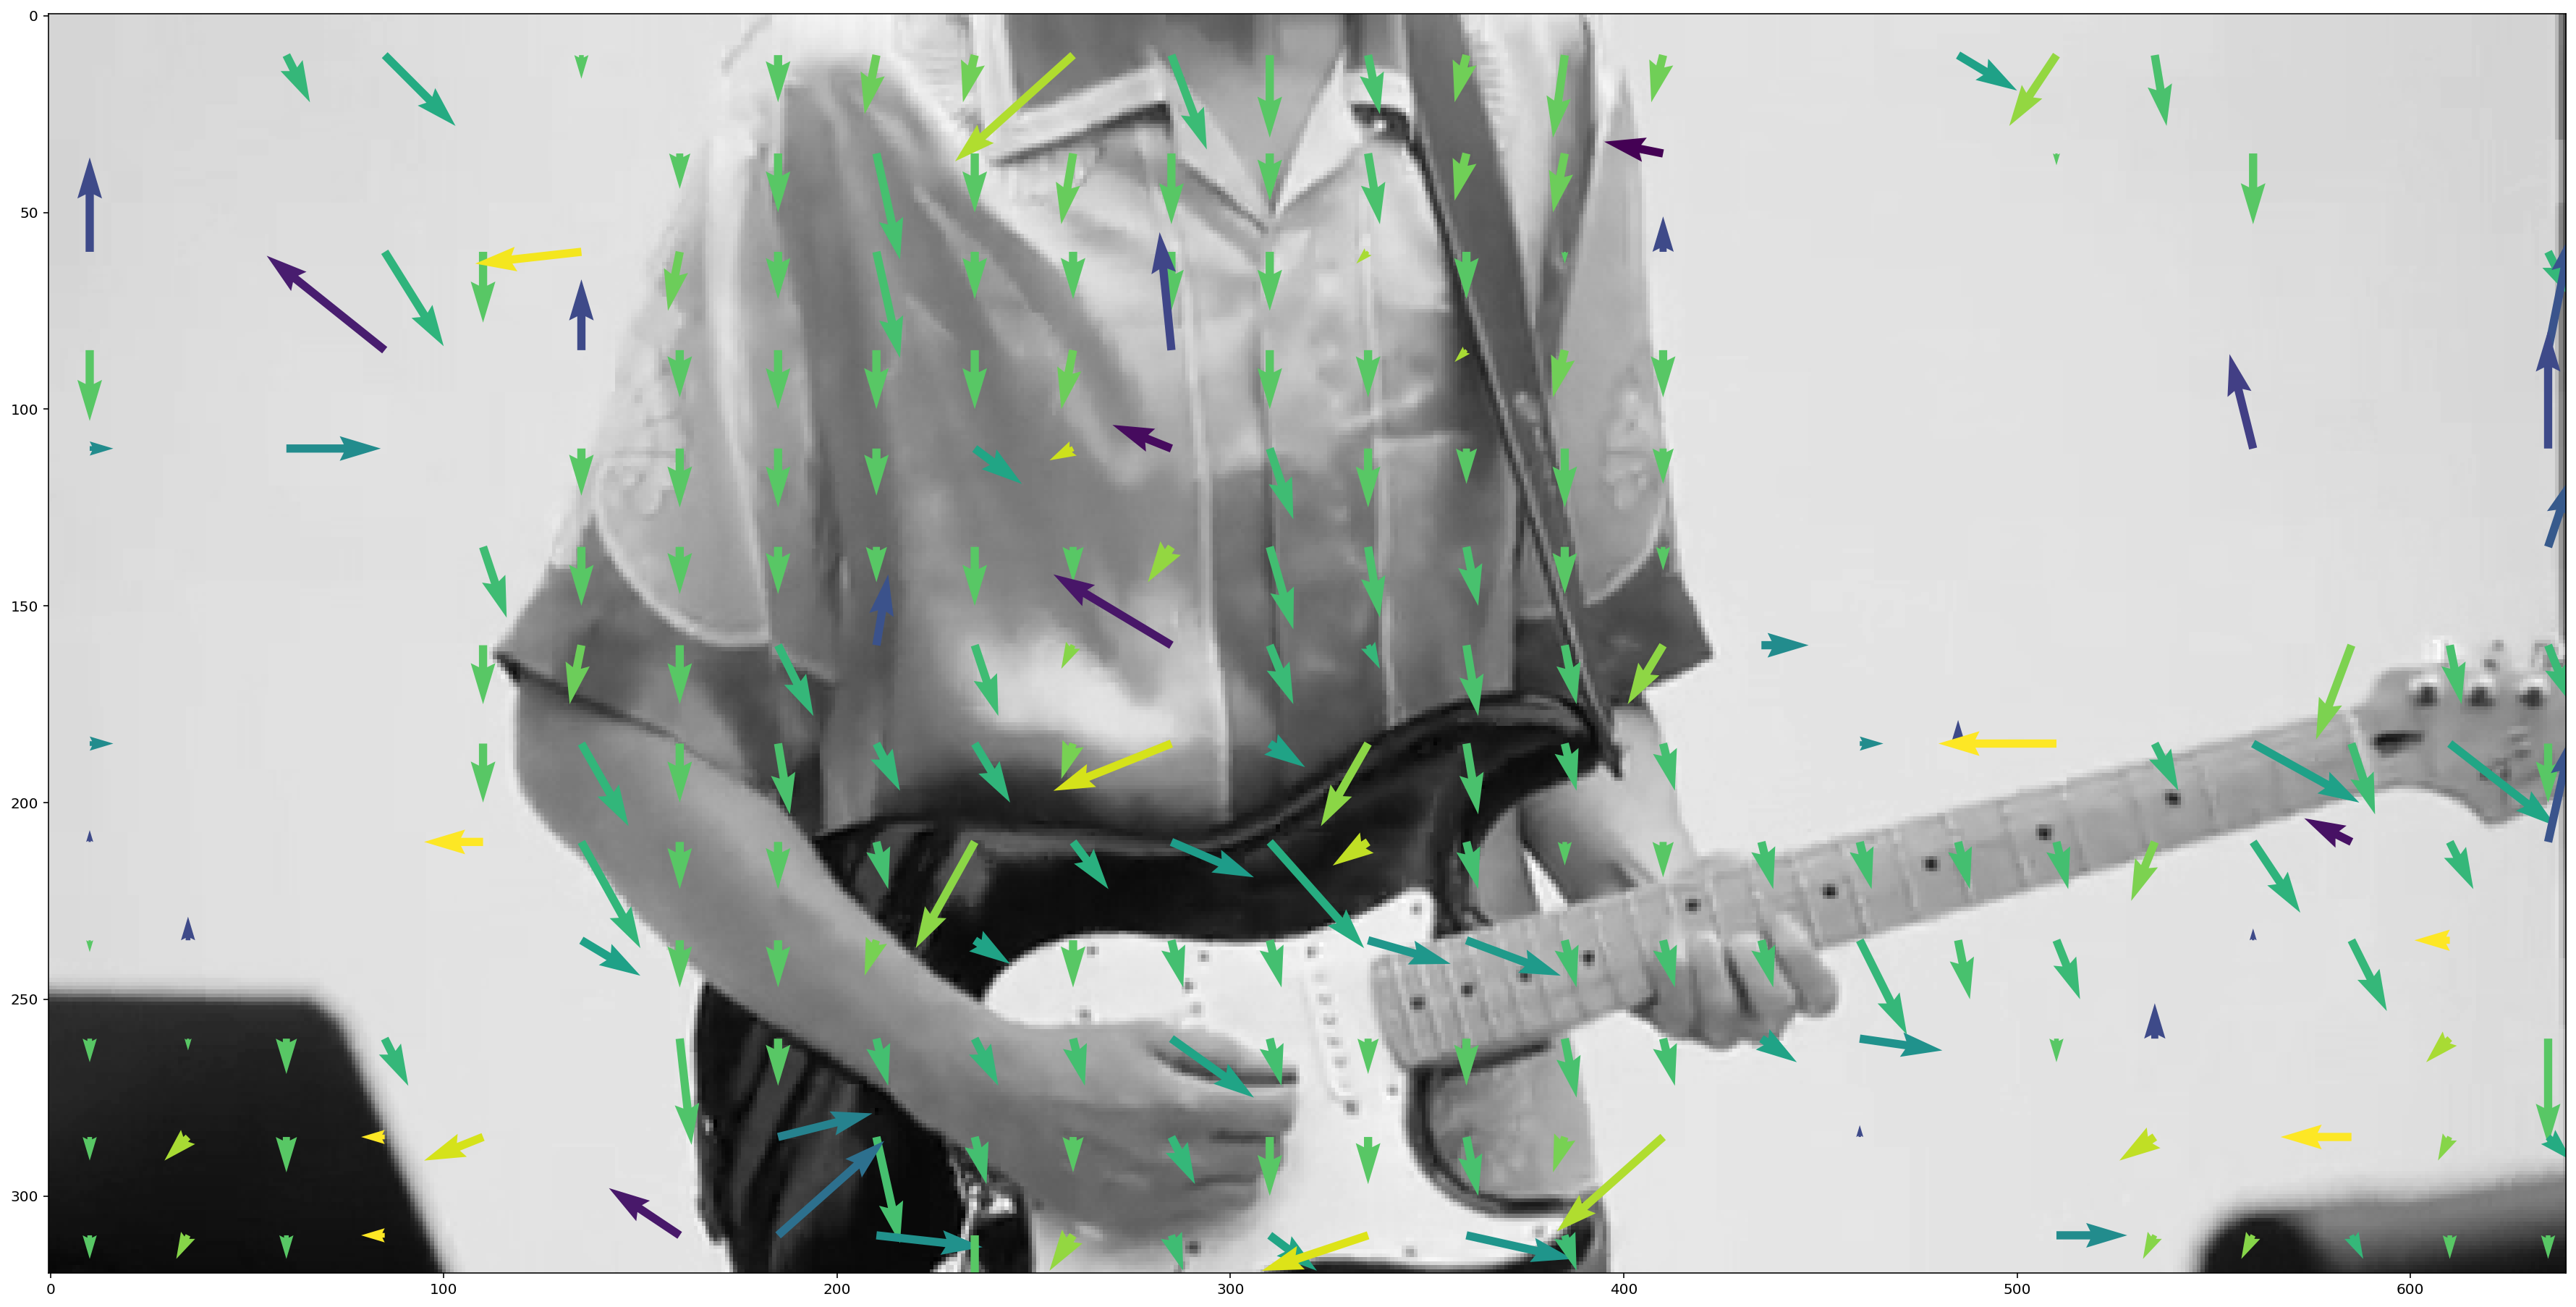

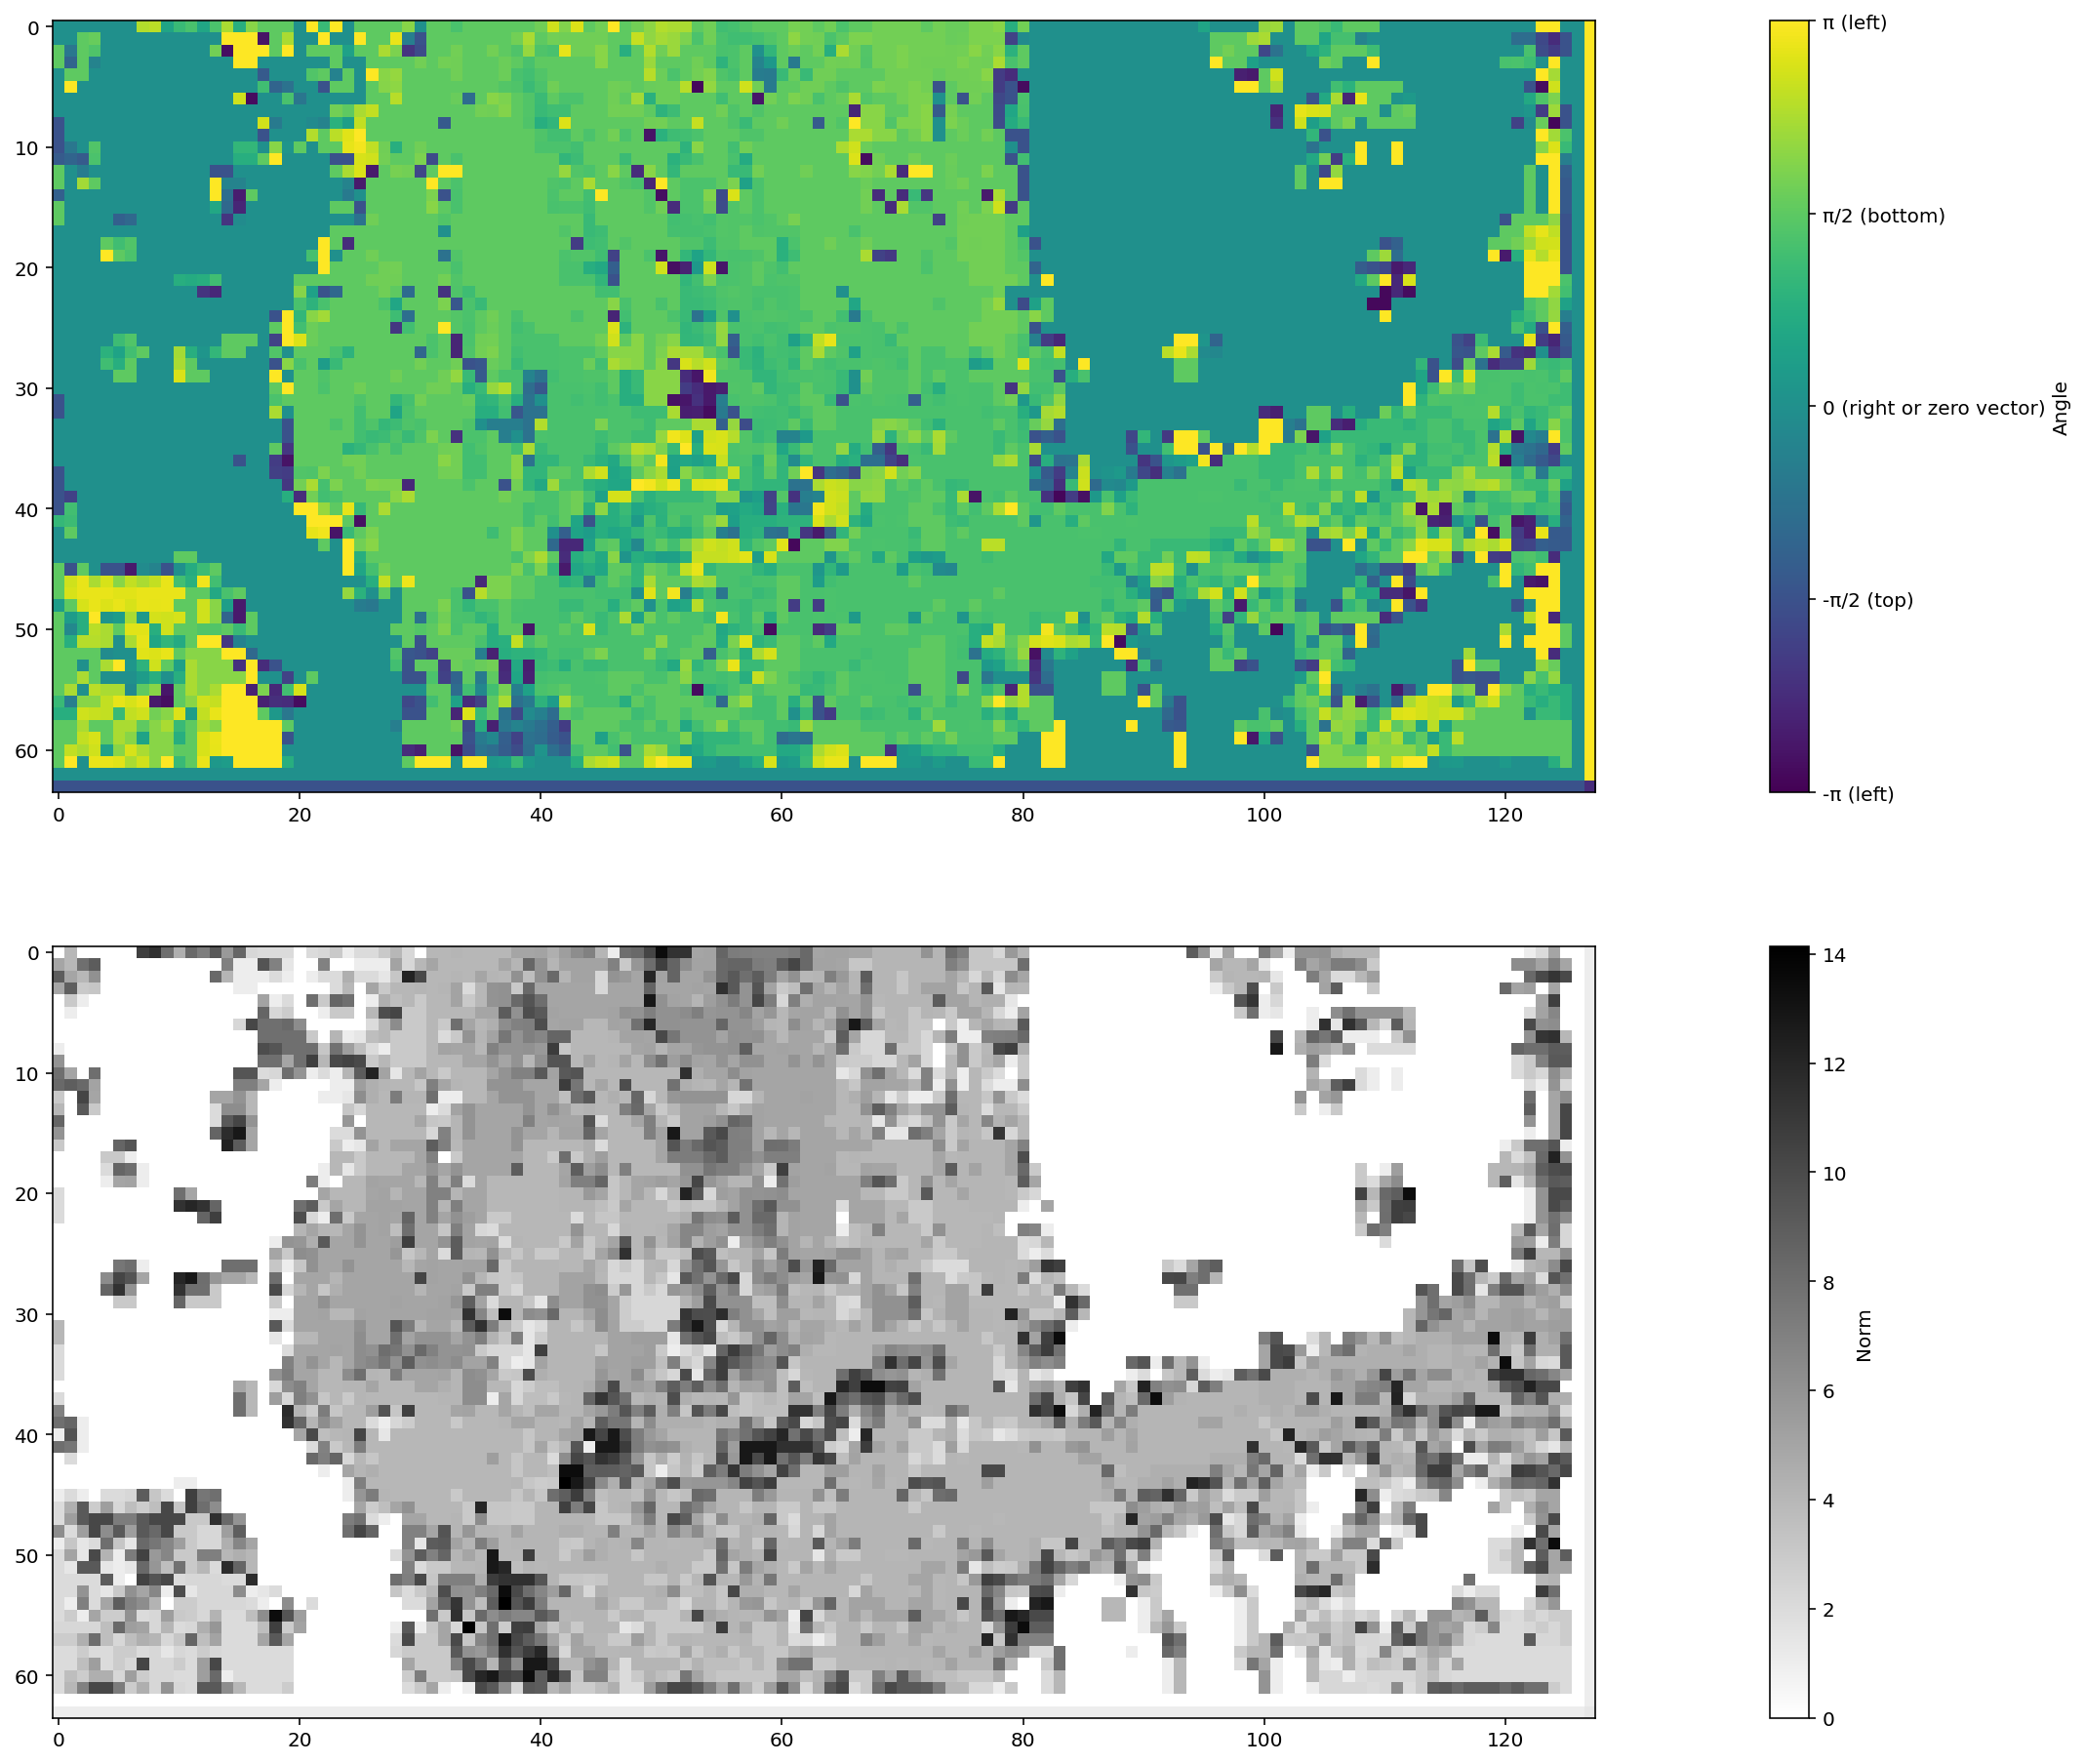

In [12]:
bma_imgs(0, 1, 5, 10)

The movement is more clear than the PMA, but it's still noisy and some elements of the background are also moving.

Processing of the movement on the first two frames for a block_size of 10 and a range of 15

  0%|          | 0/32 [00:00<?, ?it/s]

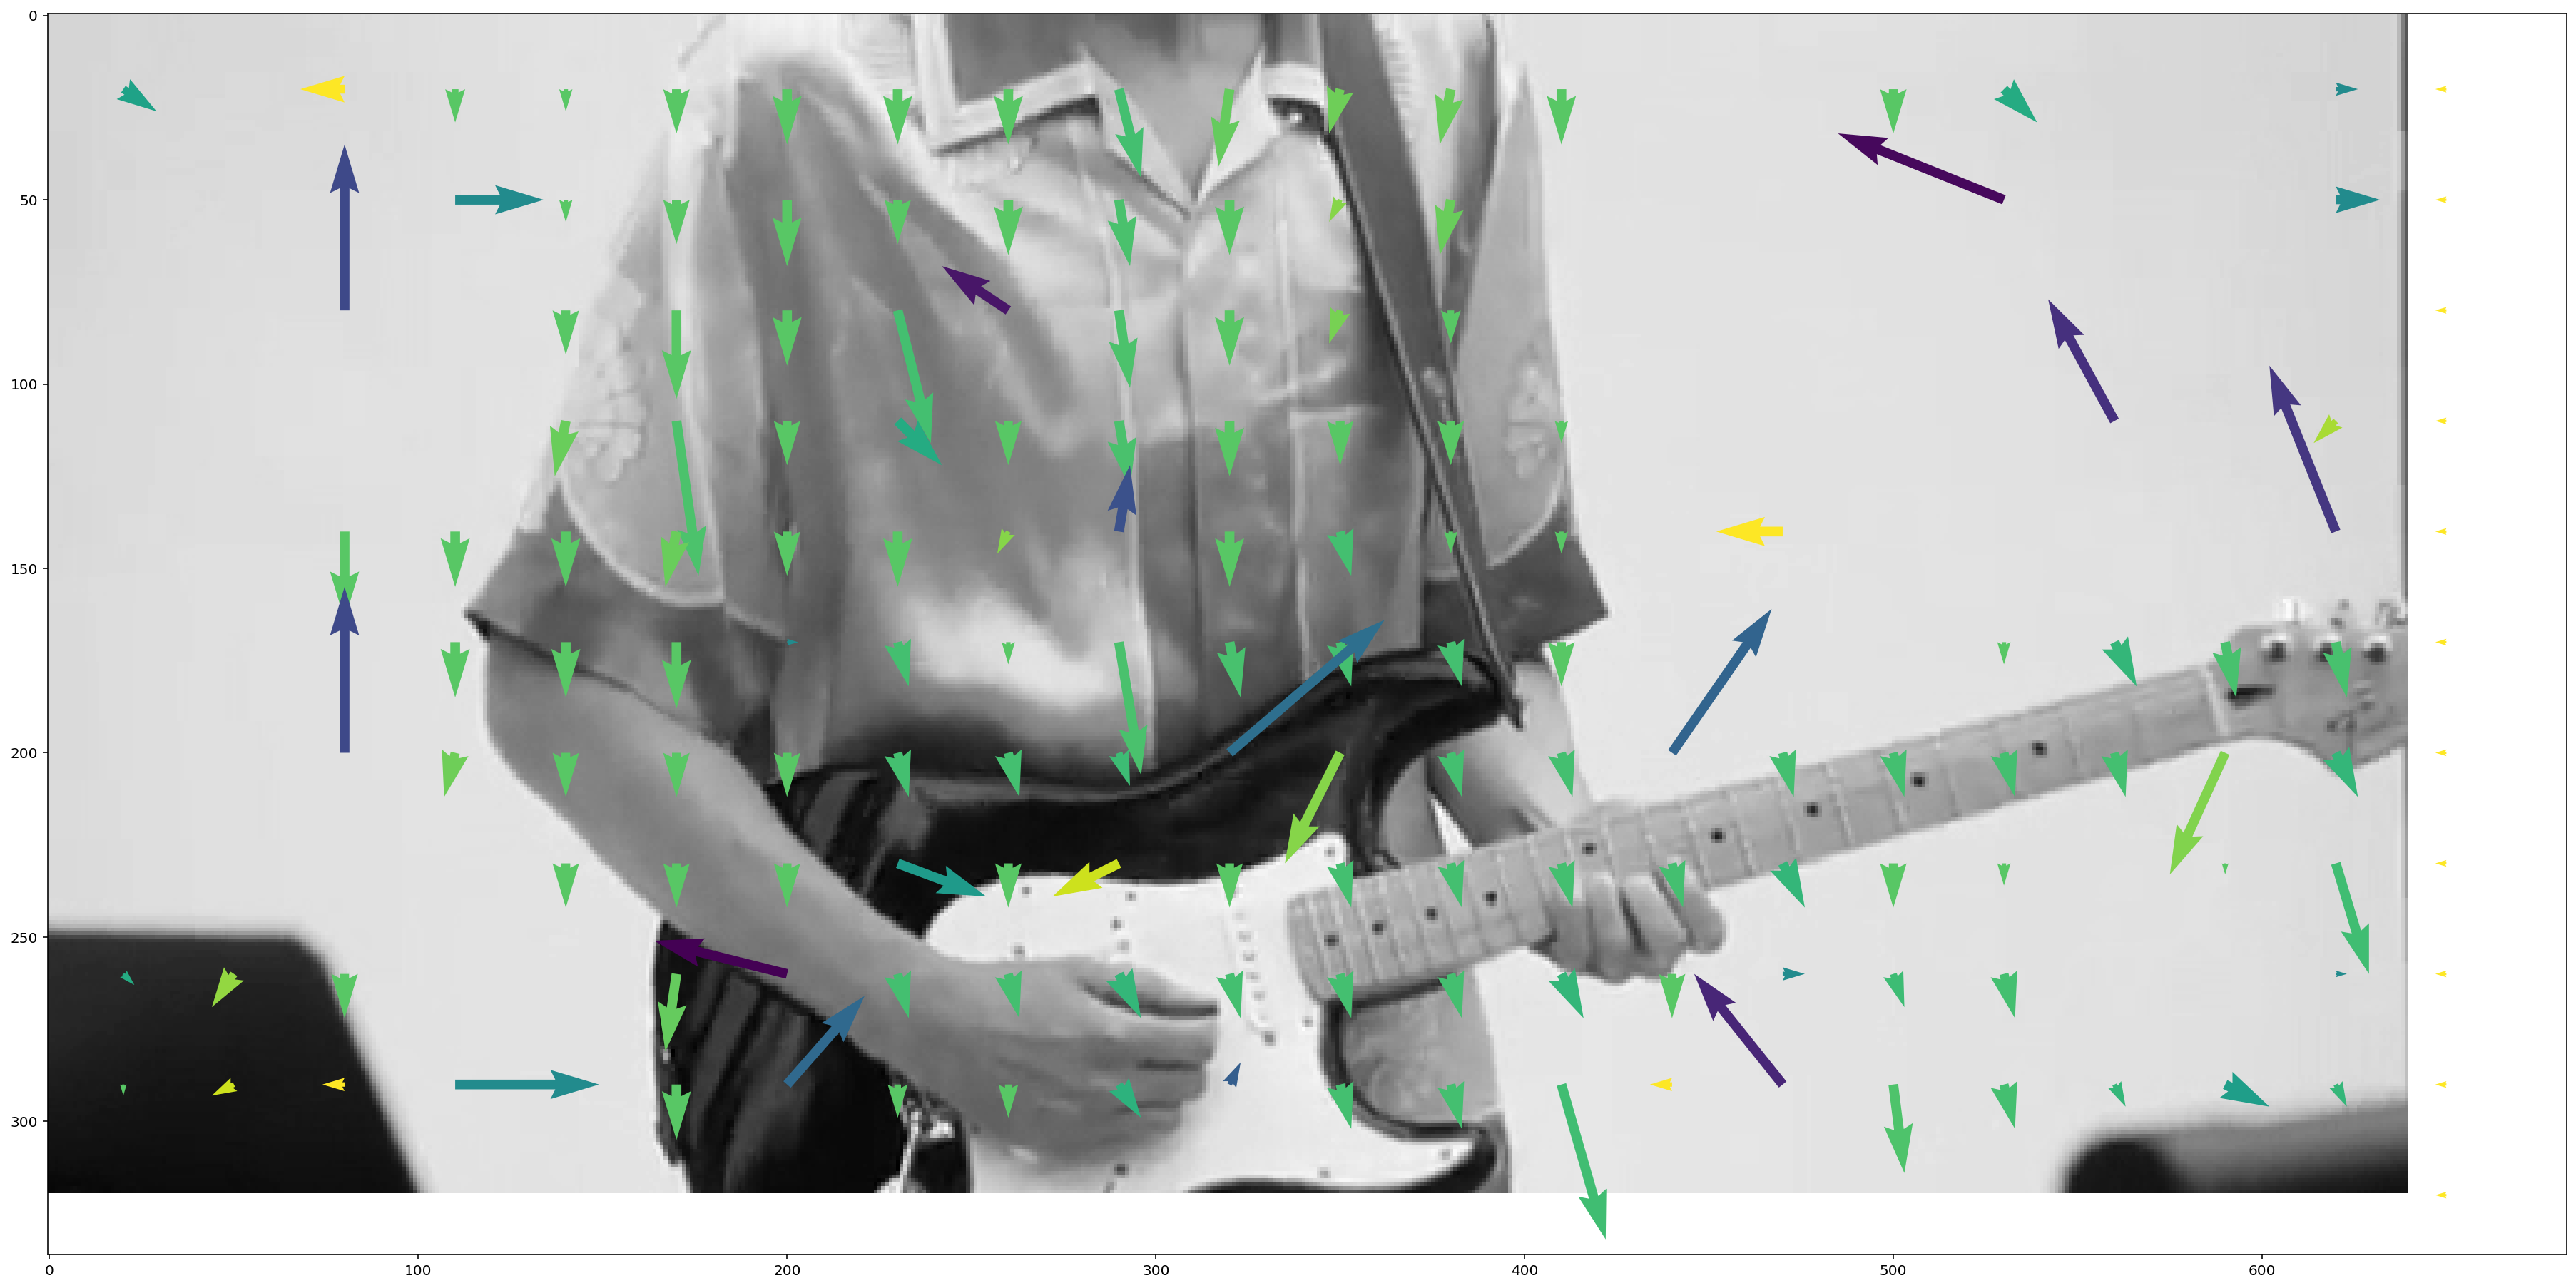

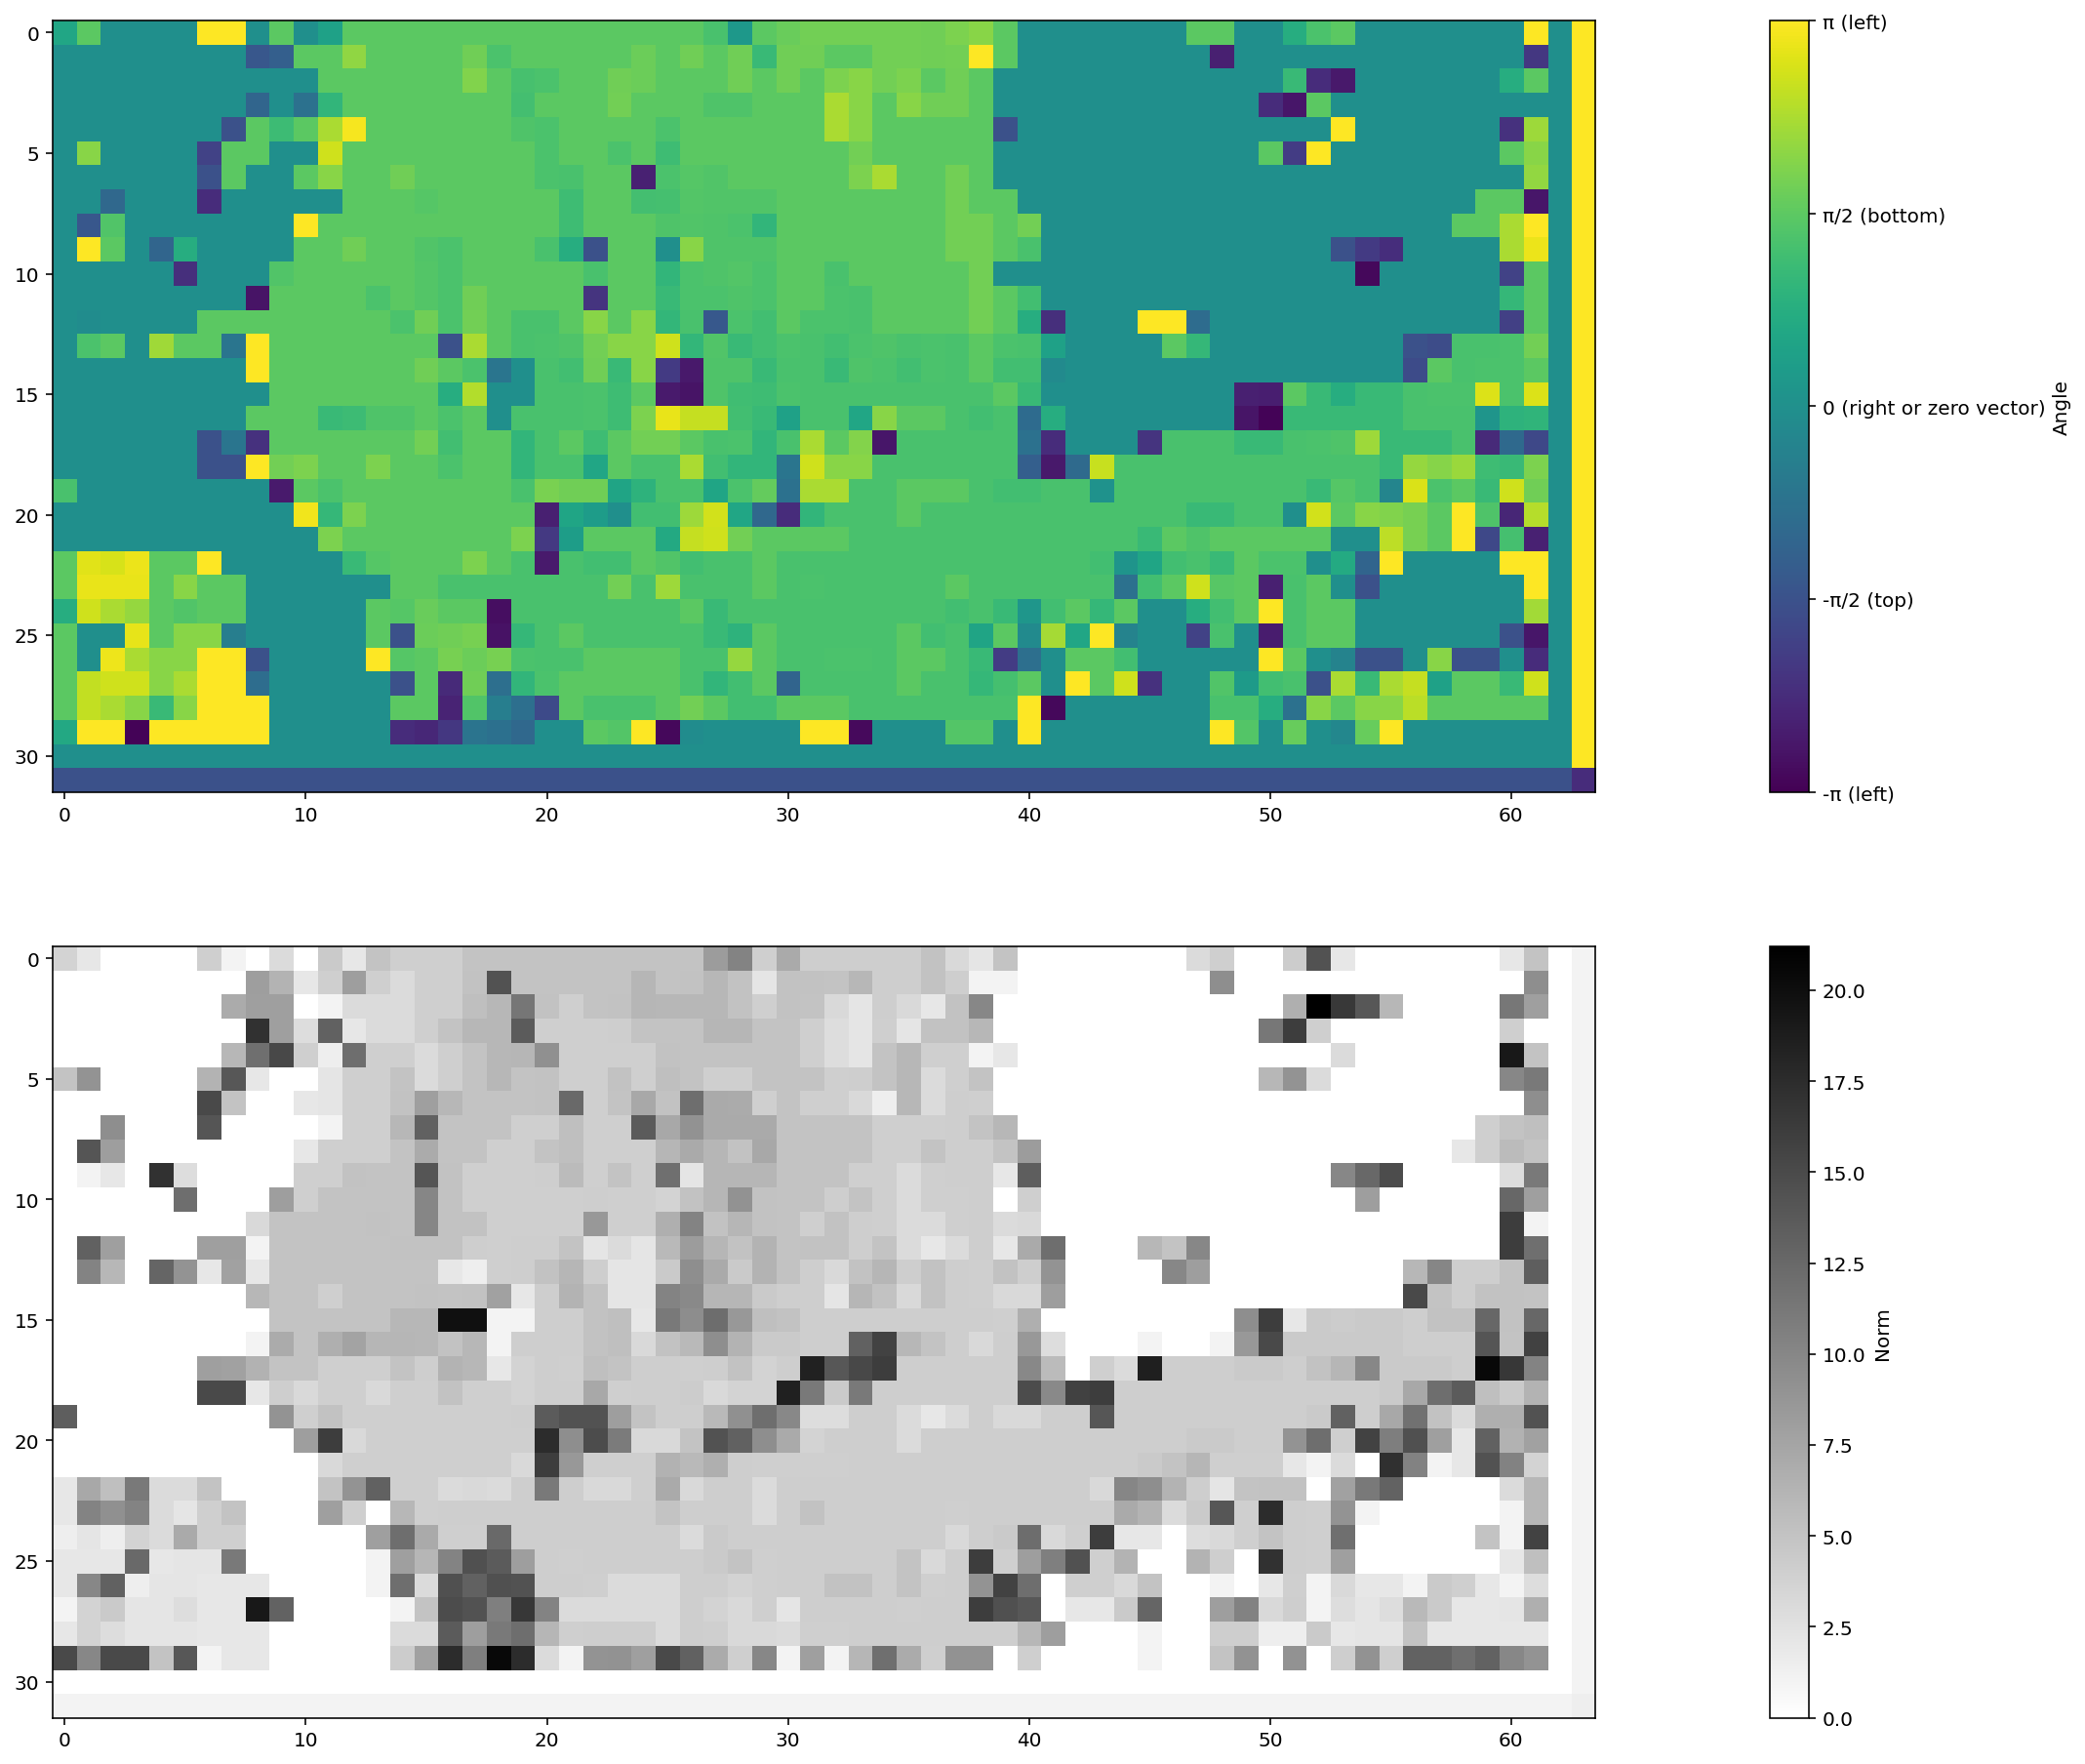

In [13]:
bma_imgs(0, 1, 10, 15)

By increasing the block size and the range, we obtain a movement that is more clear and a background that is more stable.

Processing of the movement on the first two frames for a block_size of 25 and a range of 30

  0%|          | 0/12 [00:00<?, ?it/s]

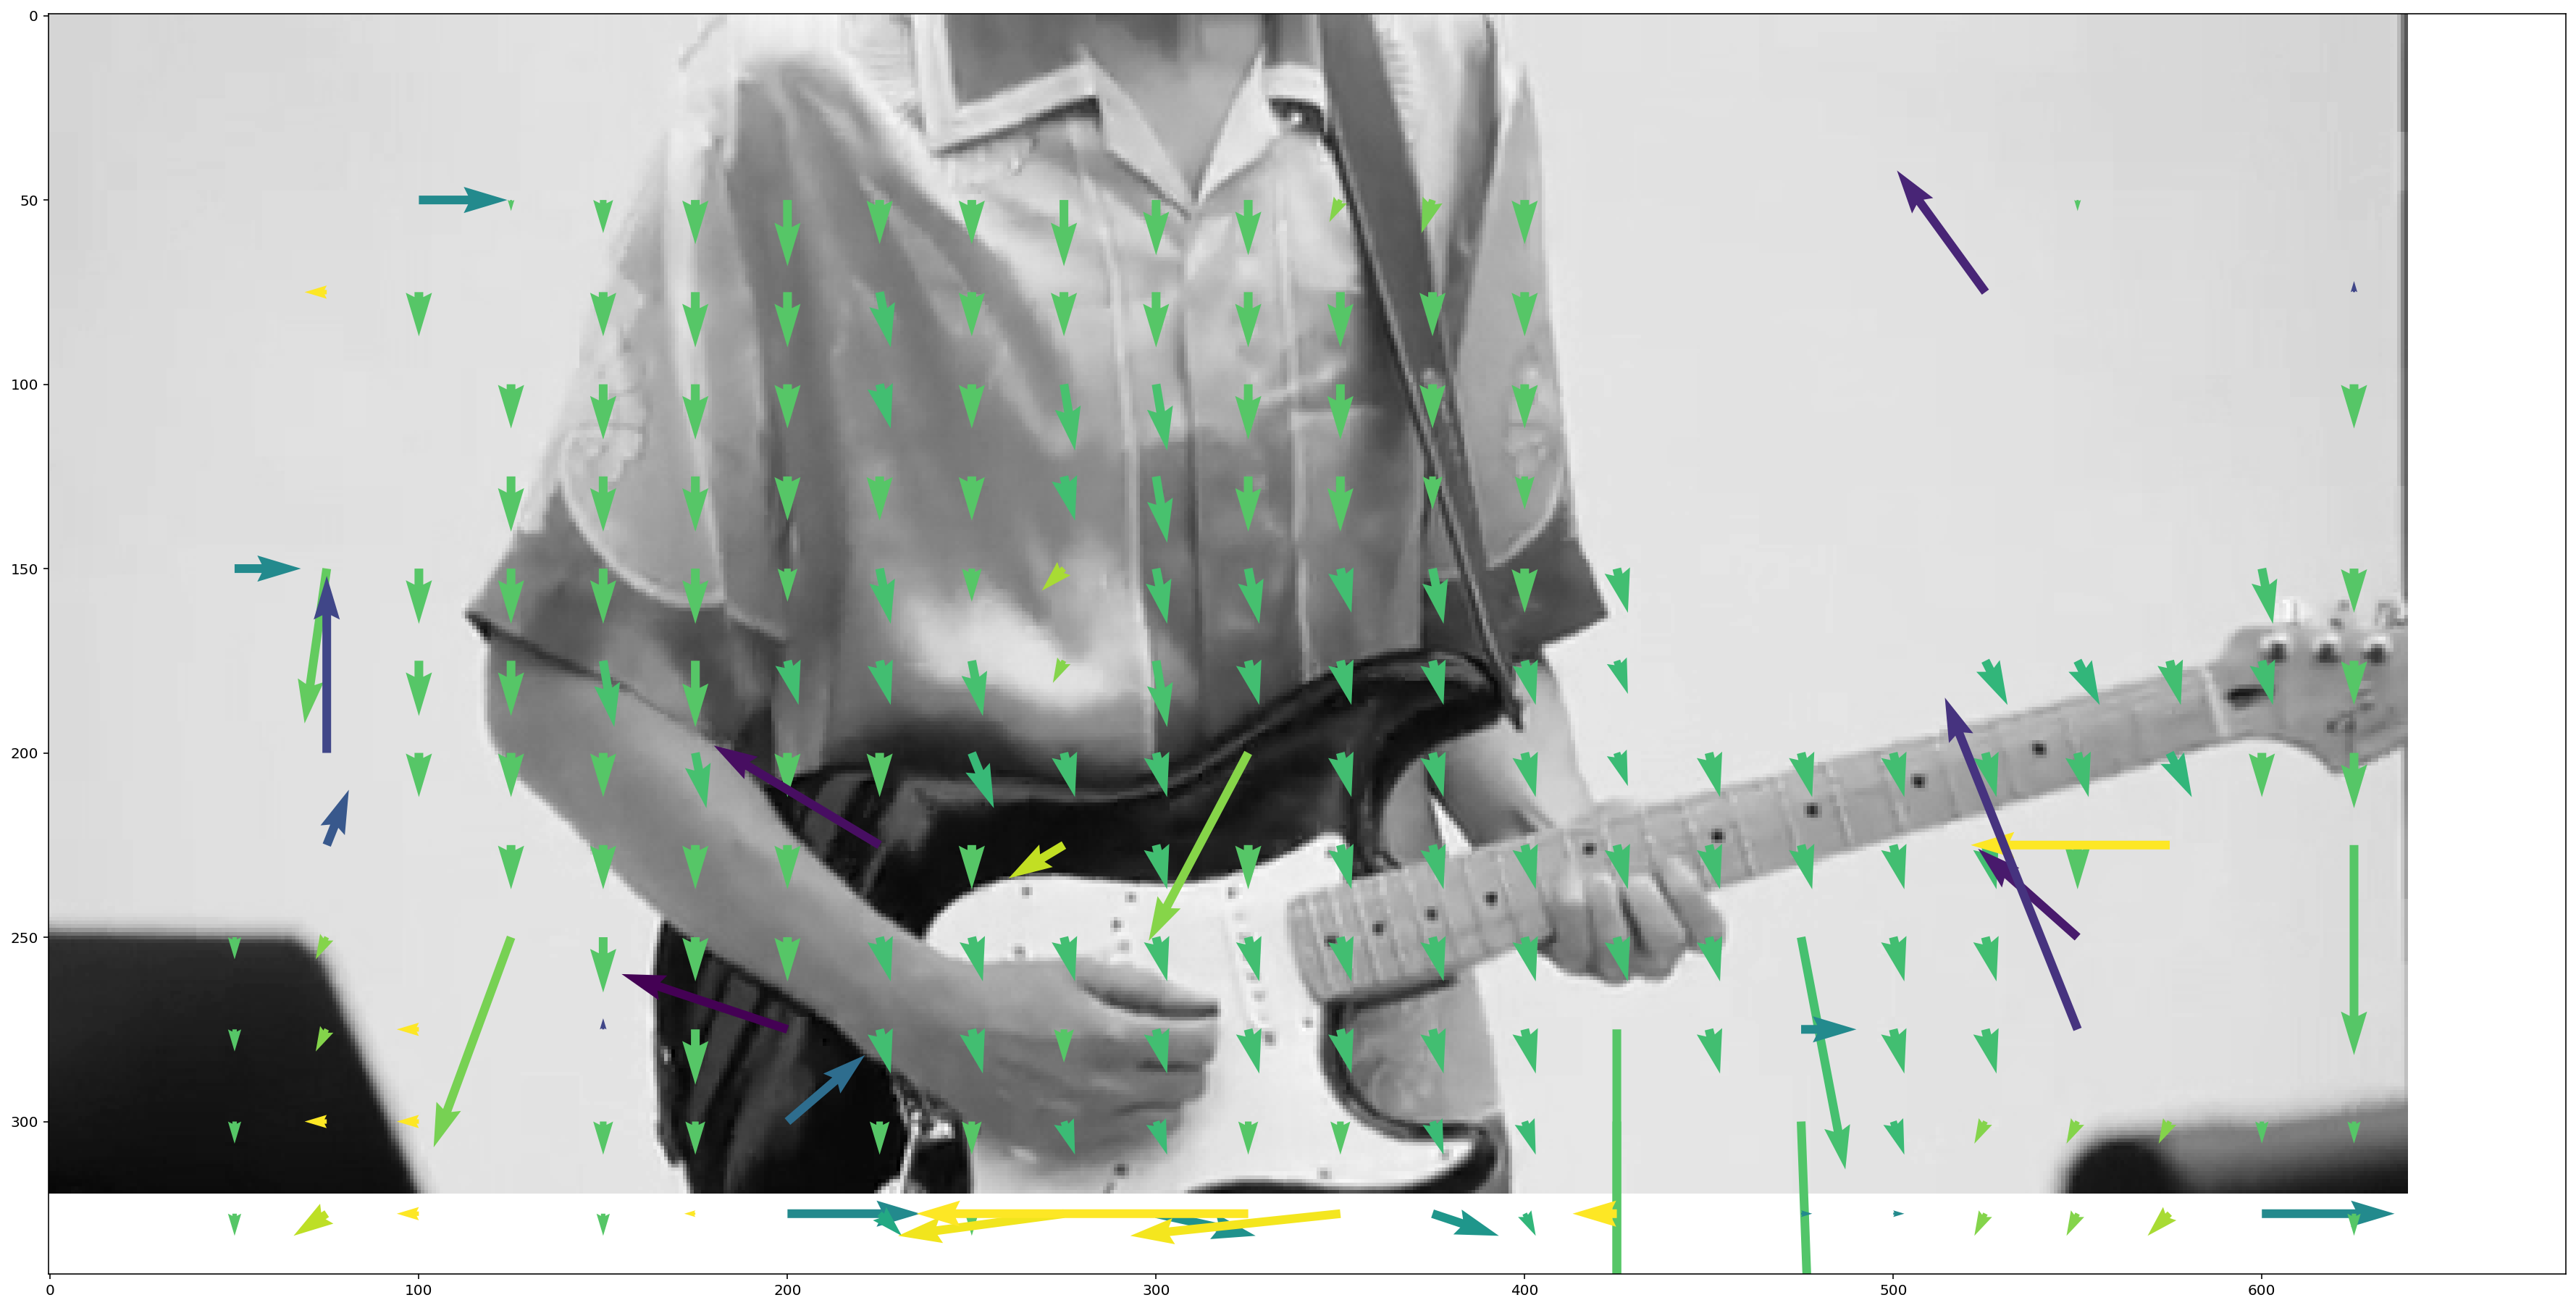

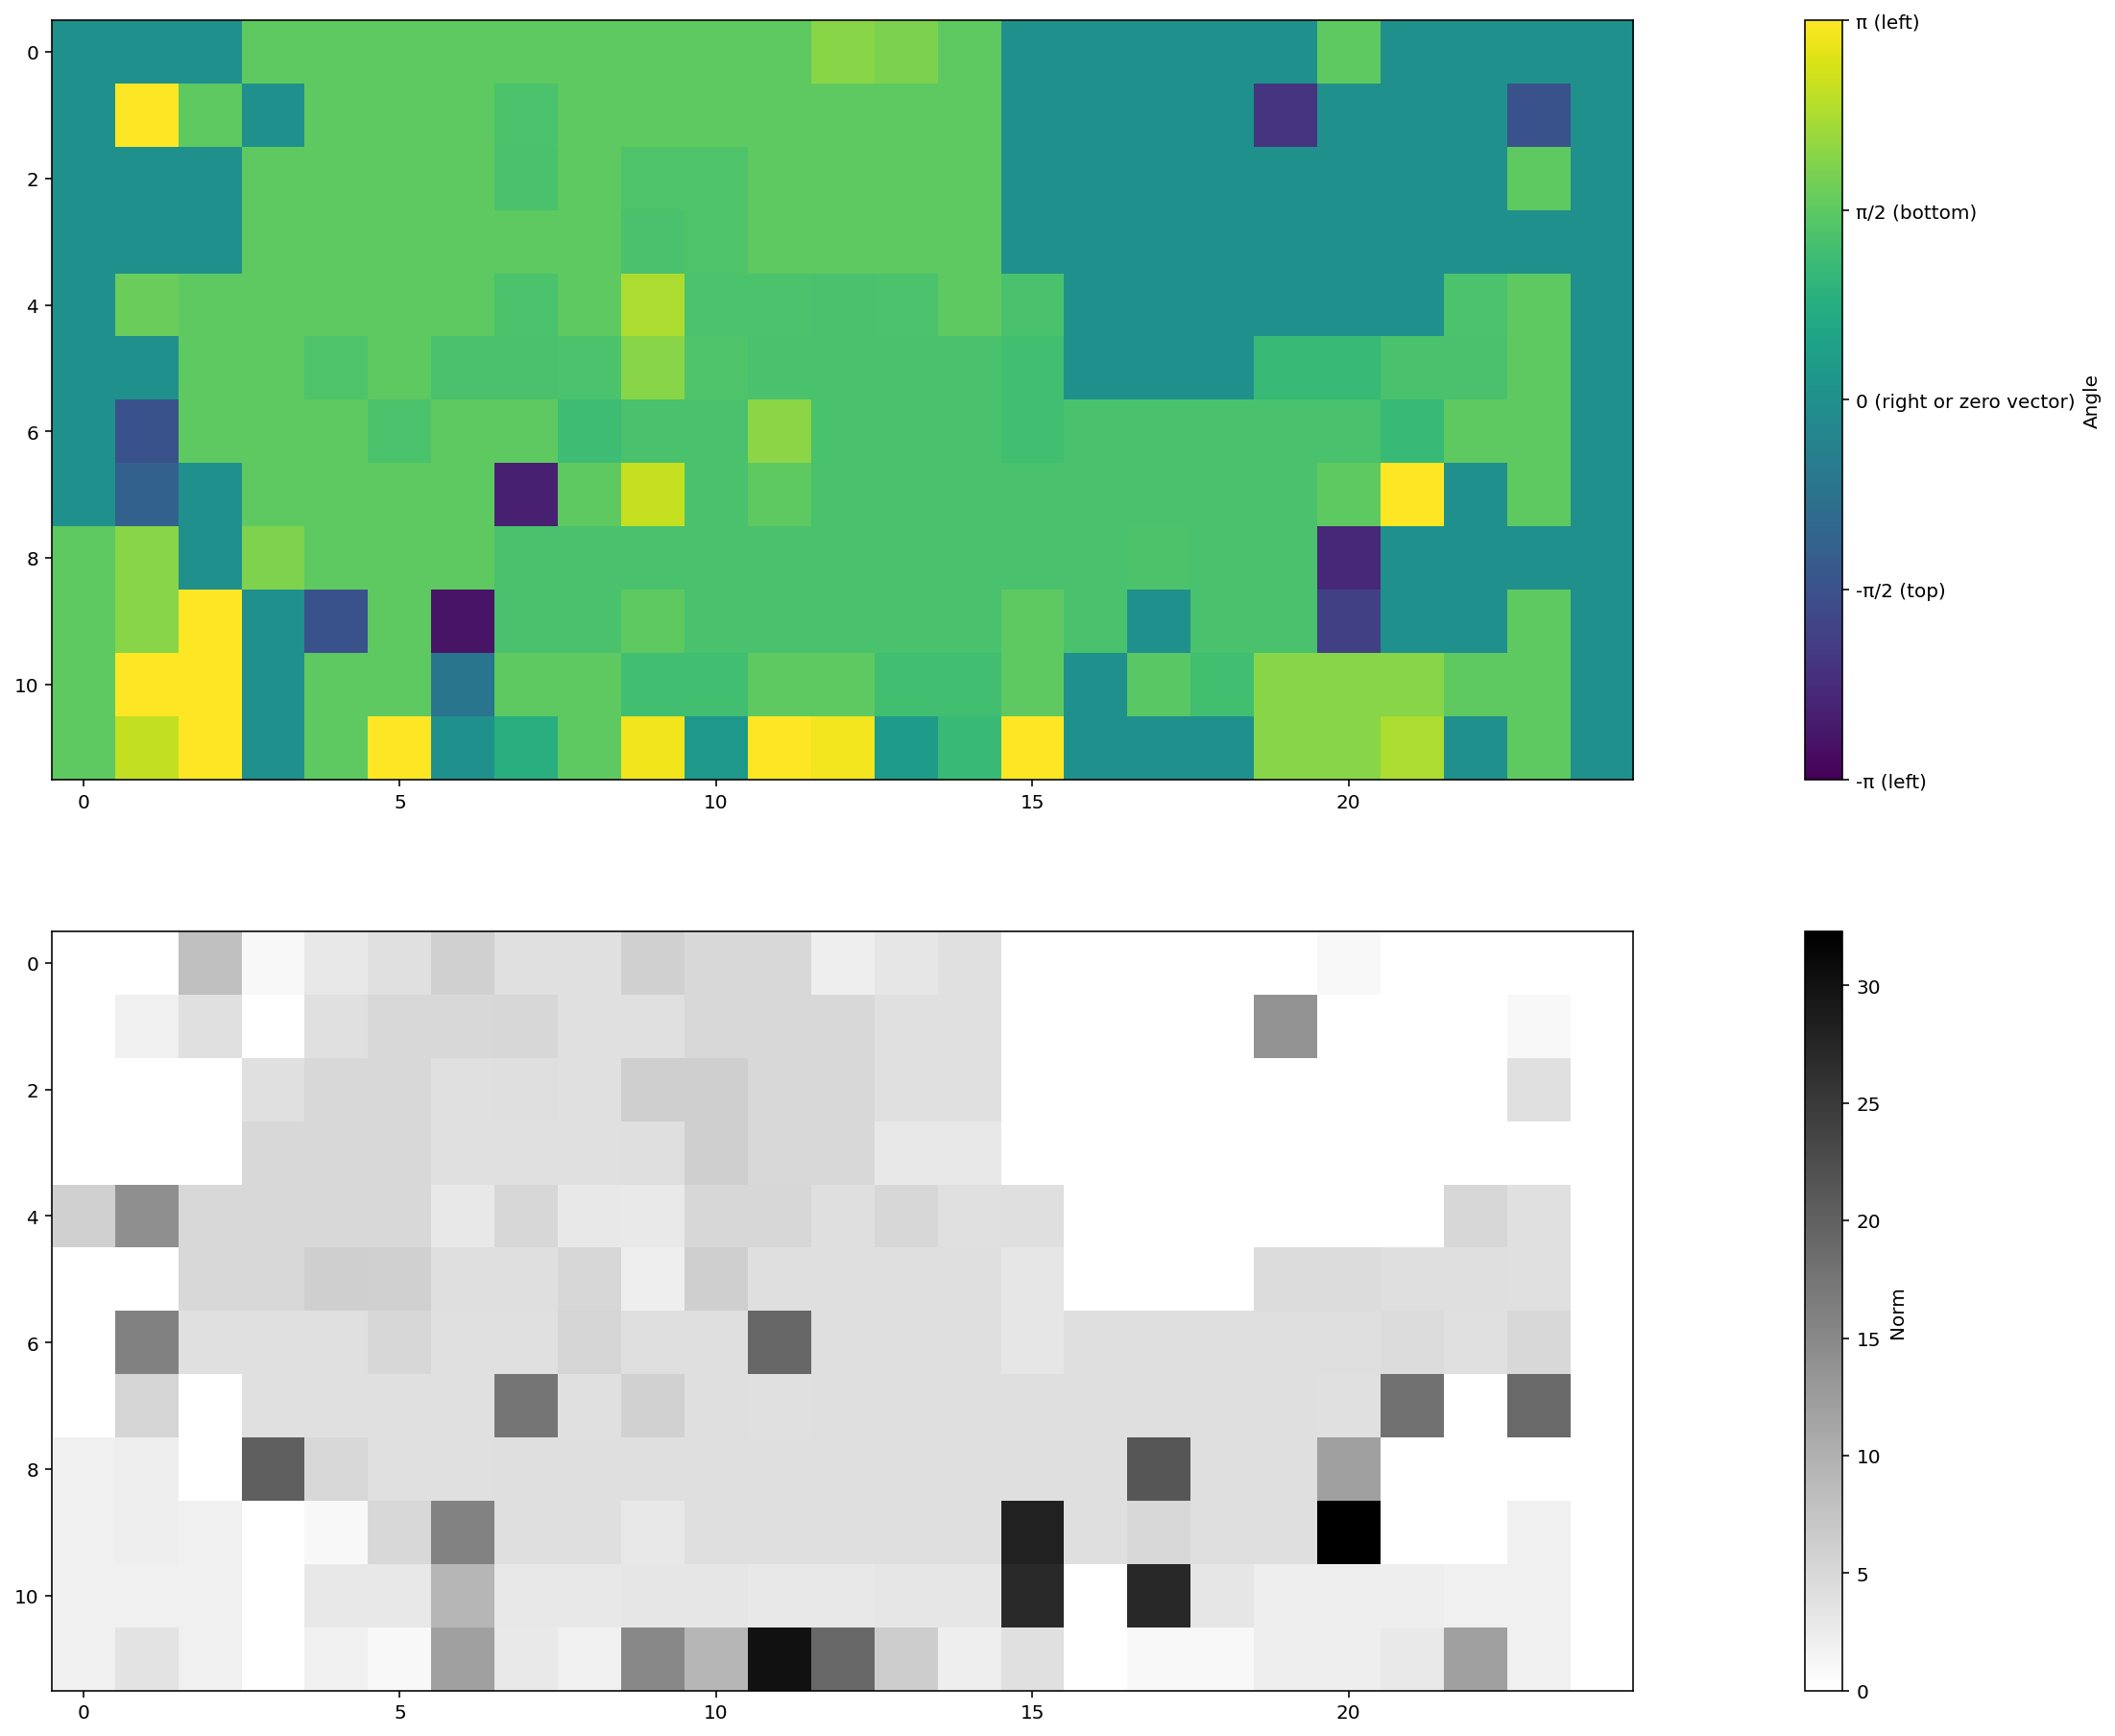

In [14]:
bma_imgs(0, 1, 25, 30)

I would say this is the best result so far on the guitarist sample, even though there are still some outliers.

### (C) Que déduisez vous des deux premières questions ?
J'en déduis que la taille des blocs influe fortement sur la régularité du champs de vecteurs de mouvement, en effet plus celle-ci est grande plus le champ de vecteurs de mouvement est régulié et cohérent avec le mouvement réel, de plus les formes des objets sont plus définies par le mouvement et beaucoup moins par les bords des objets (exemple : les motifs de la chemise sont ignorés au profit du mouvement ou les cordes de la guitare).

### (D)

#### (D.1) Ajout d'une méthode de régularisation du champ de vecteurs de mouvement

In [15]:
def bma_block_smoothed(frame1, frame2, block_size, search_range, lambda_smoothness=0.1):
    """
    Calculate the motion vector matrix using the BMA algorithm
    """

    # Gray the frames to get intensity images (human eye gray)
    frame1 = rgb2gray(frame1)
    frame2 = rgb2gray(frame2)

    # Ignore borders of the image to avoid border cases
    # Possible improvement : pad with zeros instead
    hpad = block_size // 2 + search_range
    wpad = block_size // 2 + search_range

    # Calculate blocs per image size (constant across all frames)
    height, width = frame1.shape
    b_height, b_width = np.array(frame1.shape) // block_size

    # Vector field matrix
    vector_field = np.empty((b_height, b_width, 4), dtype=np.float32)

    # Iterate over each IP in the current frame
    for a in trange(b_height):
        for b in range(b_width):
            # Extract the current block (block around the center IP (i, j)) and avoid corners
            i, j = a * block_size, b * block_size
            current_block = frame1[i+hpad:i+hpad+block_size, j+wpad:j+wpad+block_size]

            # Initialize the error and motion vector for the window sliding block
            best_error = np.inf
            best_motion = None
            best_distance = np.inf

            # Iterate over each pixel in the search range (sliding window)
            # Max and min assure not to slide outside the image ranges
            for k in range(max(i-search_range, 0), min(i+search_range, height-block_size)):
                for l in range(max(j-search_range, 0), min(j+search_range, width-block_size)):
                    # Extract the window block from frame2
                    window_block = frame2[k+hpad:k+hpad+block_size, l+wpad:l+wpad+block_size]

                    # Calculate the mean absolute error between the current block (in frame 1)
                    # and the search block (sliding window block in frame 2) (power 1) (DFD)
                    try:
                        dfd = np.sum(np.abs(current_block - window_block))
                    except:
                        continue

                    # Compute motion smoothness penalty
                    smoothness_penalty = 0
                    if a > 0:
                        smoothness_penalty += lambda_smoothness * \
                            np.linalg.norm(np.array([k-i, l-j]) - vector_field[a-1, b][:2])
                    if b > 0:
                        smoothness_penalty += lambda_smoothness * \
                            np.linalg.norm(np.array([k-i, l-j]) - vector_field[a, b-1][:2])

                    error = dfd + smoothness_penalty

                    # Calculate the euclidian distance between the current IP and the search IP
                    # In order to prioritize the closest IP if the error is equal
                    distance =  (k - i) ** 2 + (l - j) ** 2

                    # (If the current error is lower, update the best error
                    # or if the current error is equal but the distance lower) then
                    # update the motion vector
                    if error < best_error or (error == best_error and distance < best_distance):    
                        best_error = error
                        best_distance = distance
                        best_motion = np.array([k-i, l-j, i, j], dtype=np.float32)

            # Store the best motion vector for the current IP (at the center of the block)
            # in the vector field
            vector_field[a, b] = best_motion

    return vector_field

In [16]:
def bma_imgs_smooth(i, j, block_size, search_range, alpha):
    vectors = bma_block_smoothed(images[i], images[j], block_size, search_range, alpha)
    
    # scaled up the vectors by 3 to be able to see them easily
    plot_motion_vectors(vectors, images[i], block_size * 2, 1, 3)
    plot_images_motion_vectors(vectors, images[i].shape)

  0%|          | 0/12 [00:00<?, ?it/s]

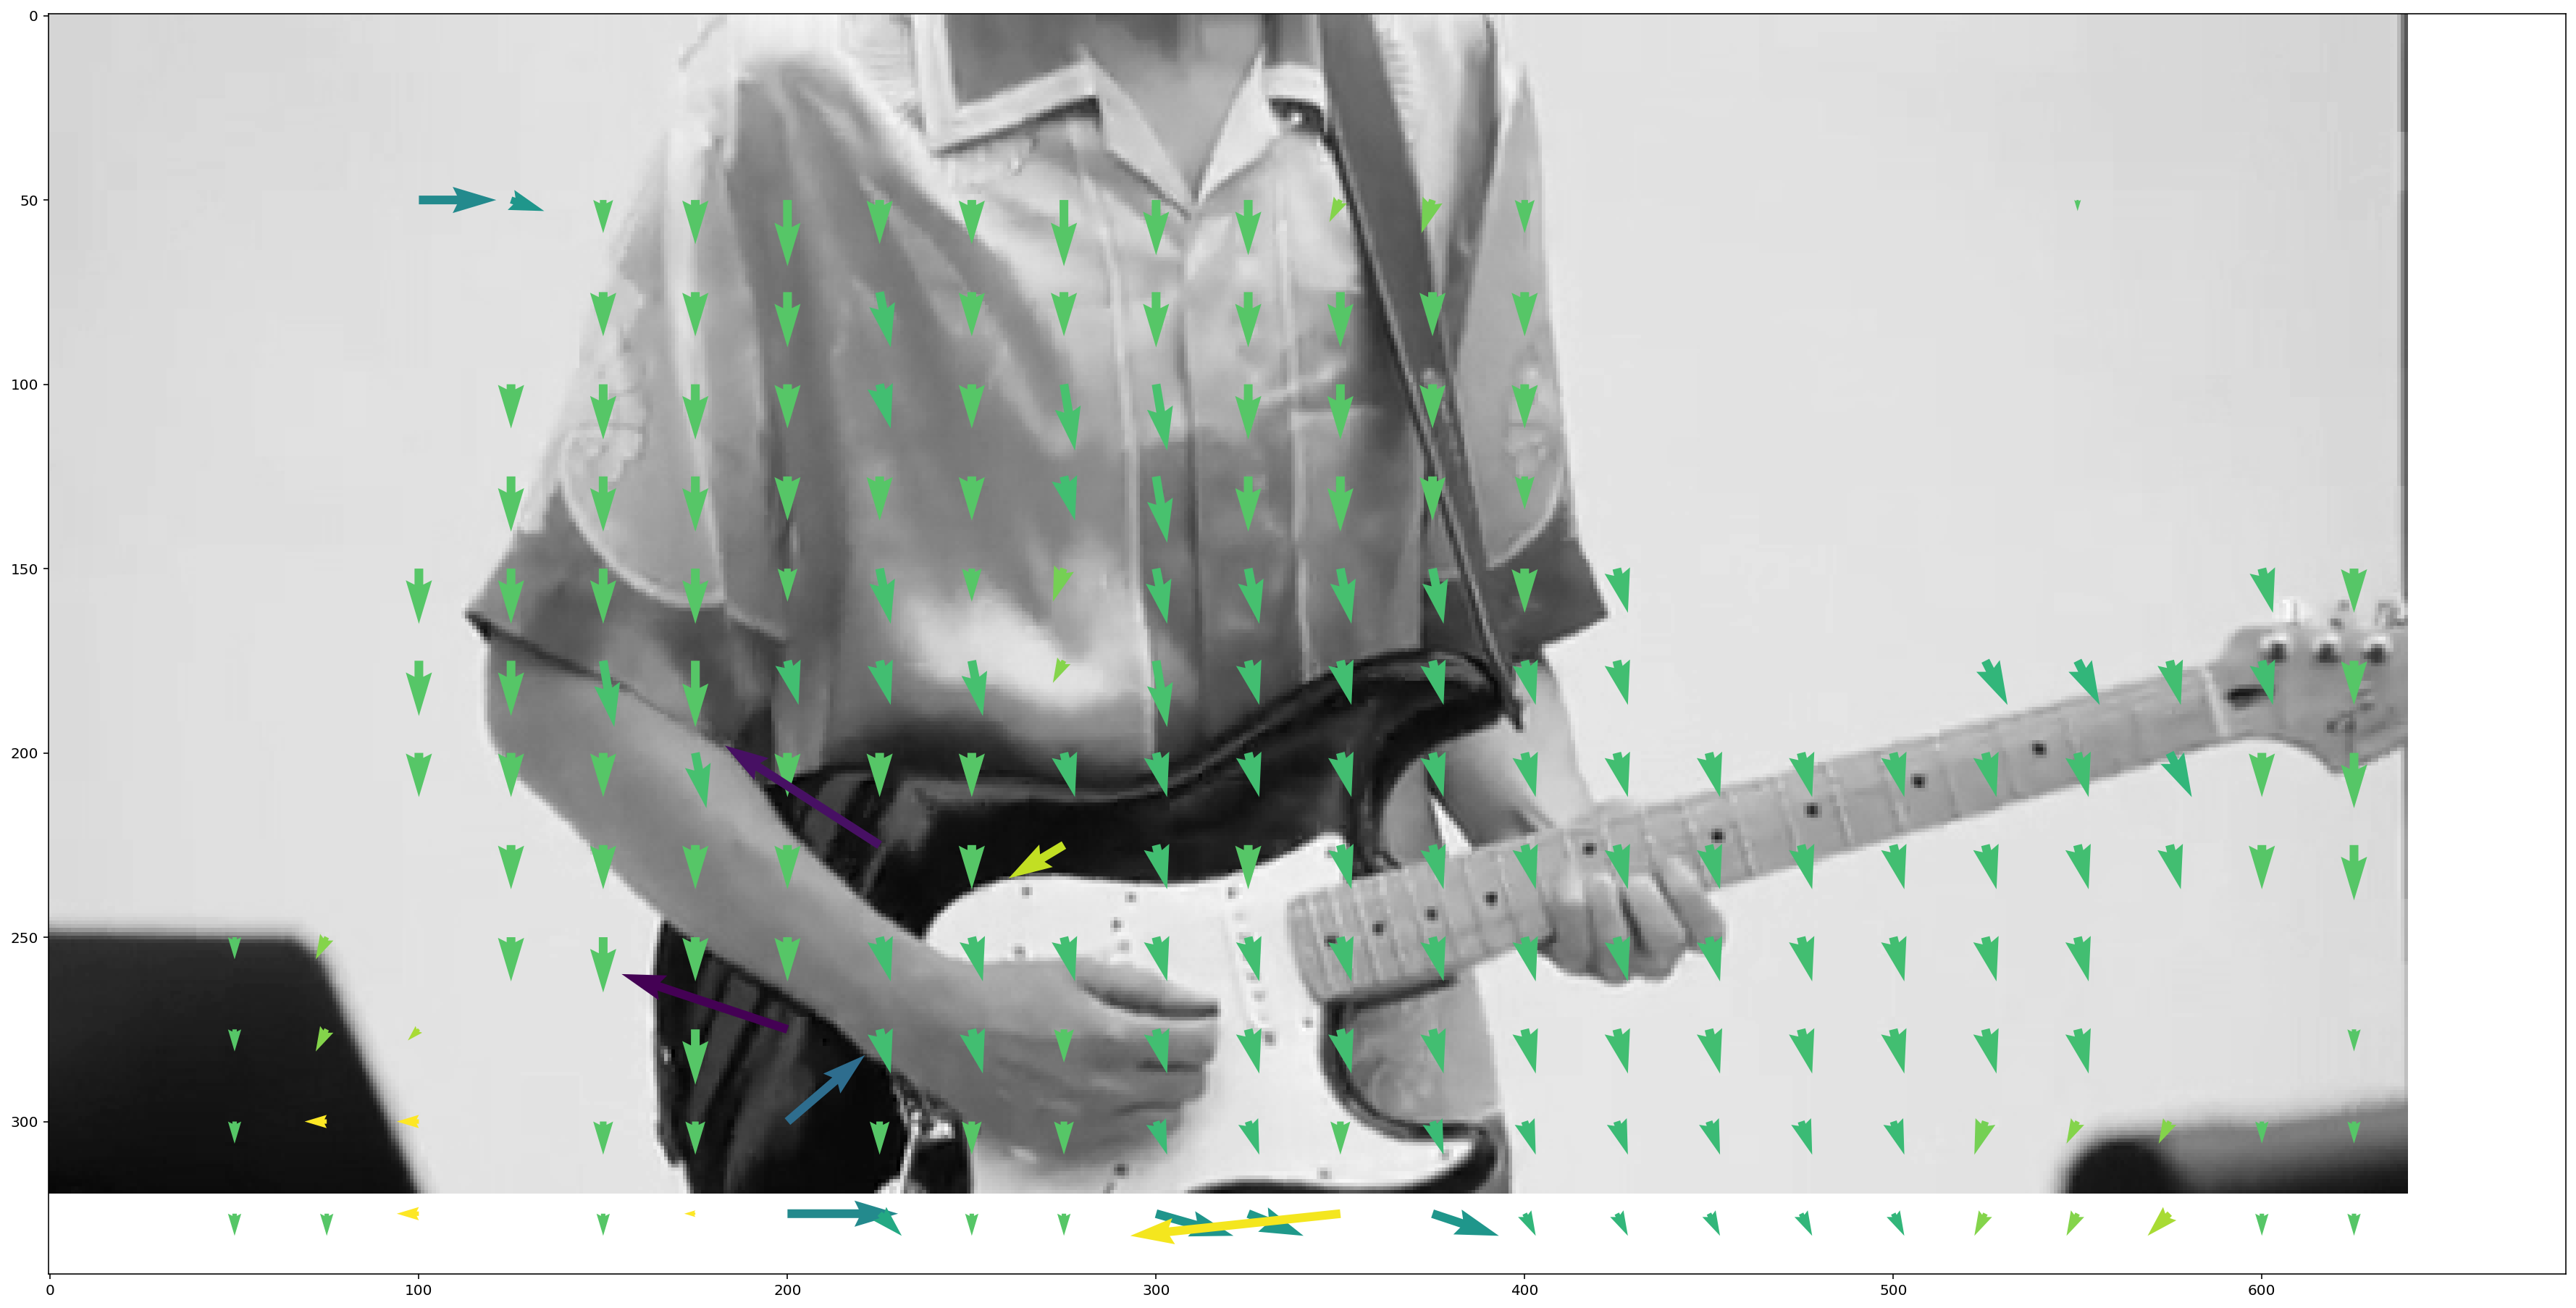

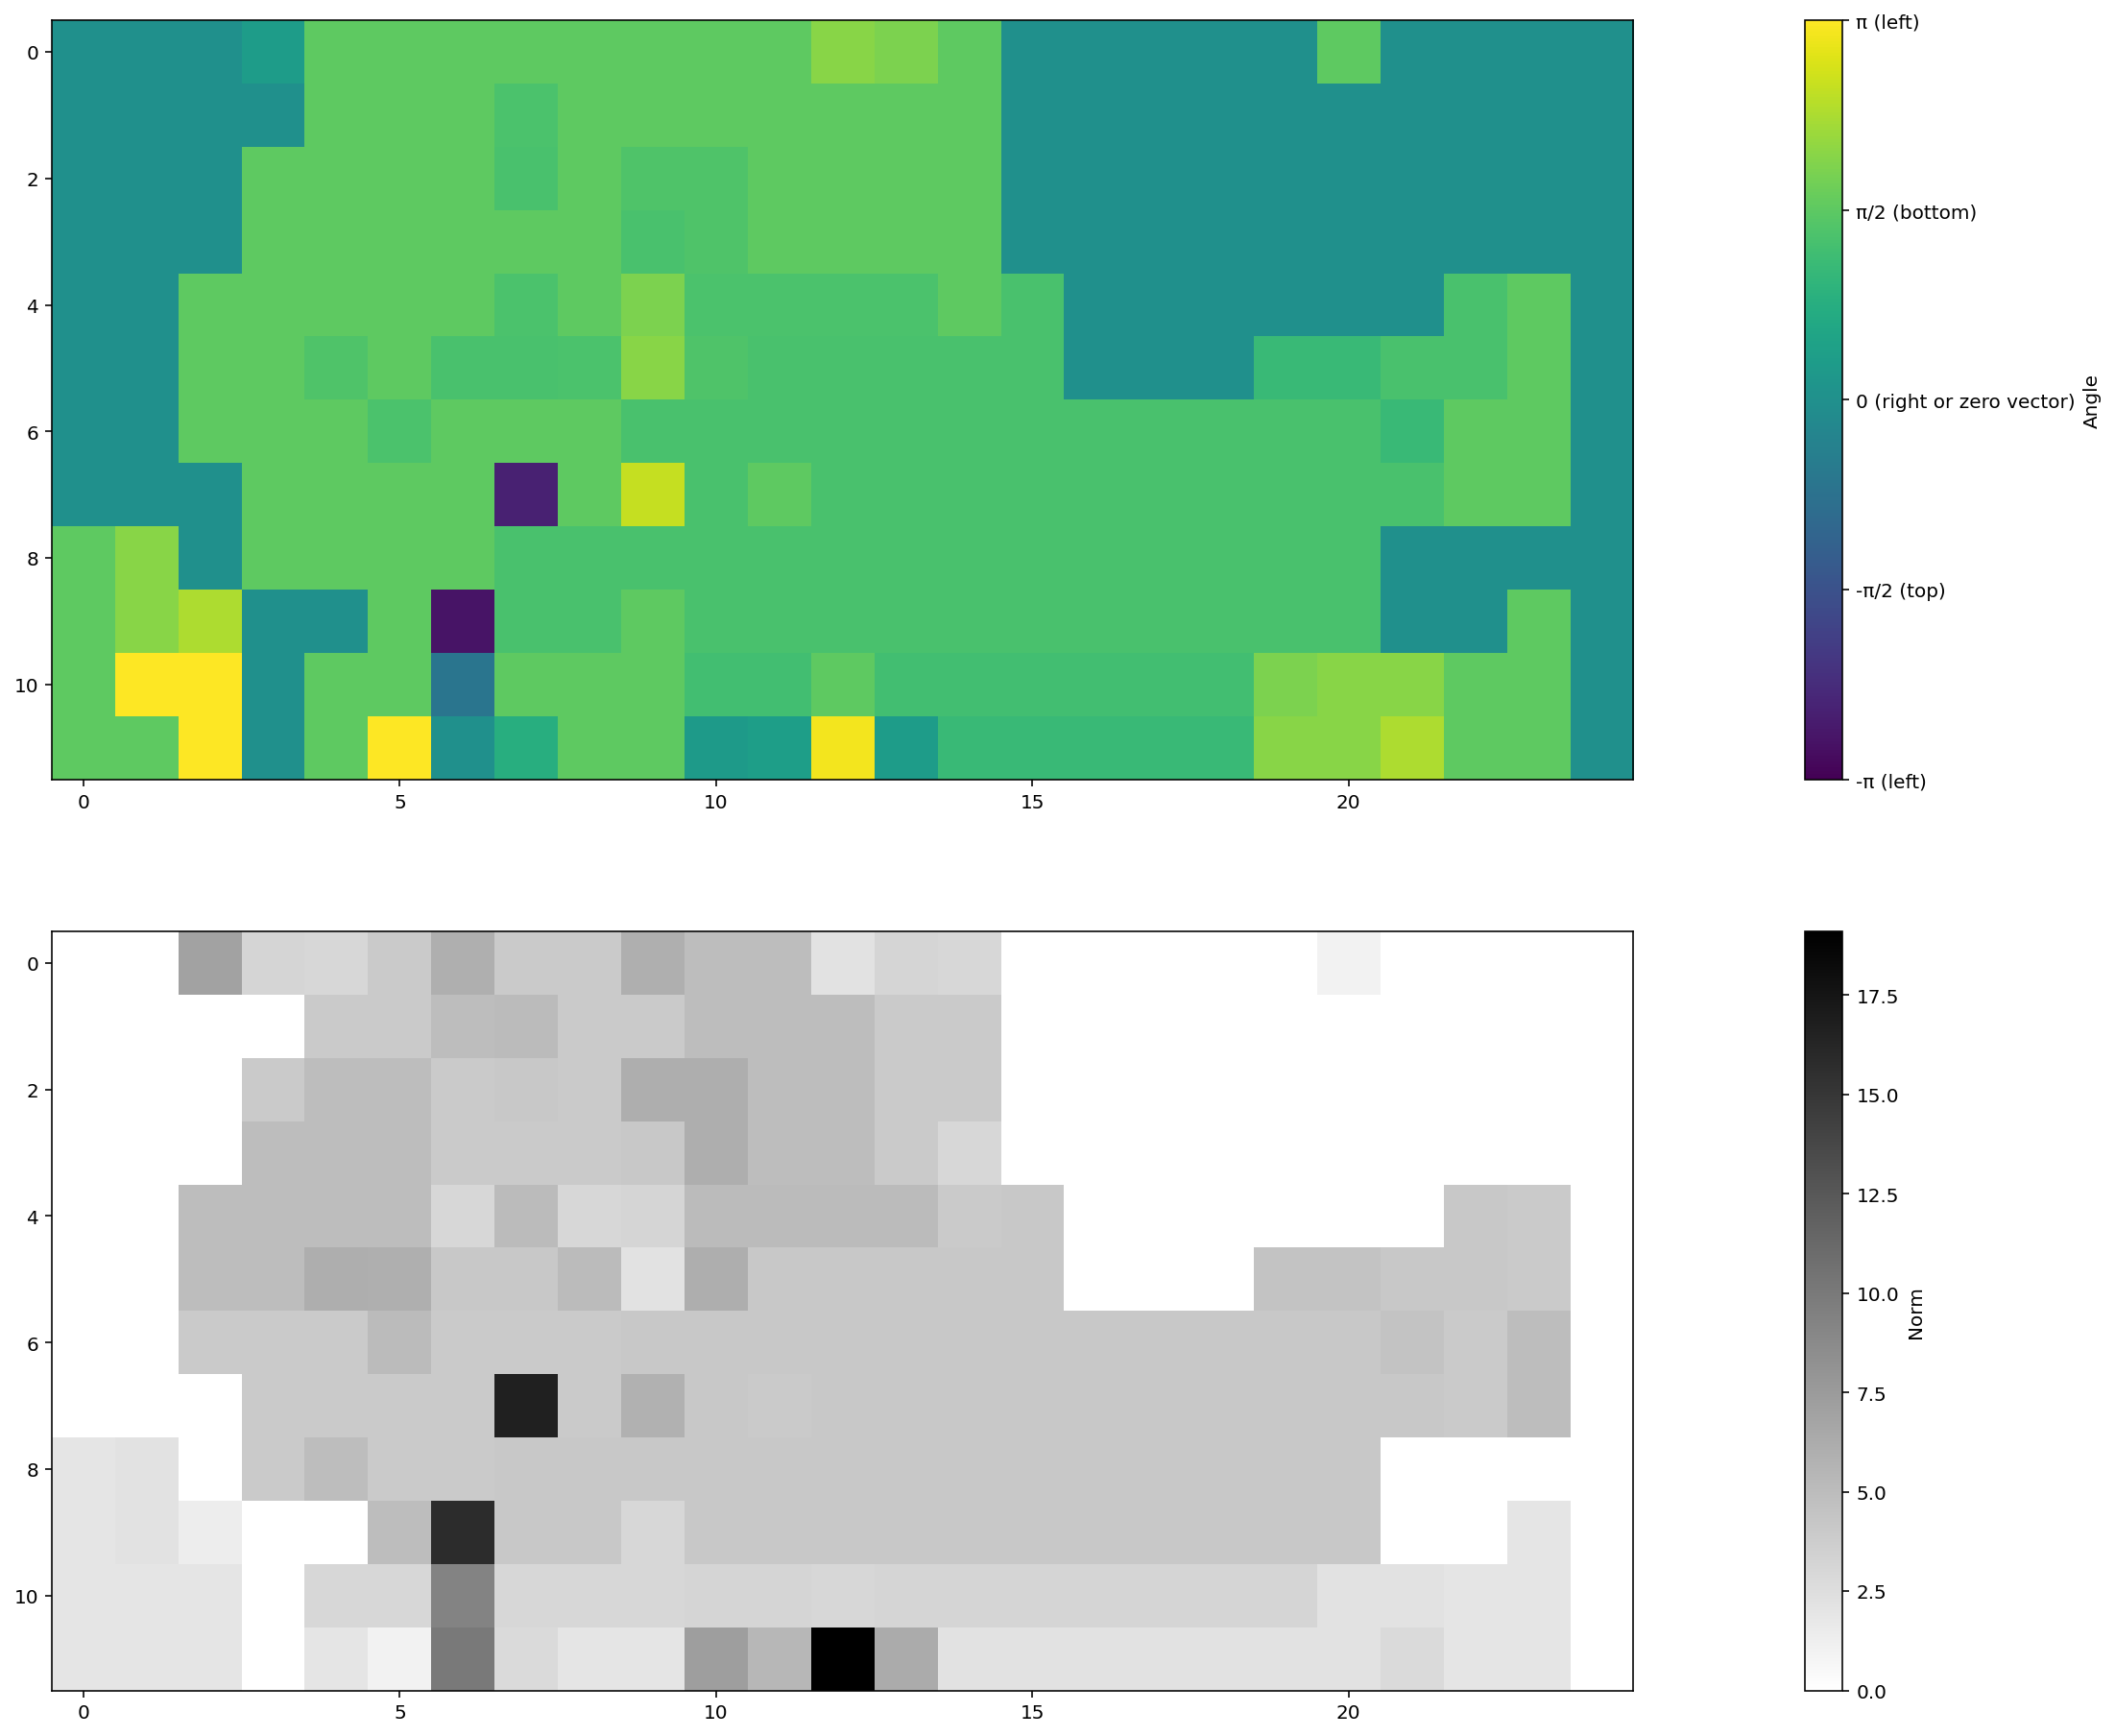

In [17]:
bma_imgs_smooth(0, 1, 25, 30, 0.1)

The regularization method clearly had an impact on the movement vectors, it made them more regular and less noisy.

In [18]:
# Load the images from the directory and normalize them
images_node_based = []
for filename in glob.glob('images2nodebased/*.png'):
    images_node_based.append(np.asarray(image.imread(filename)))

  0%|          | 0/24 [00:00<?, ?it/s]

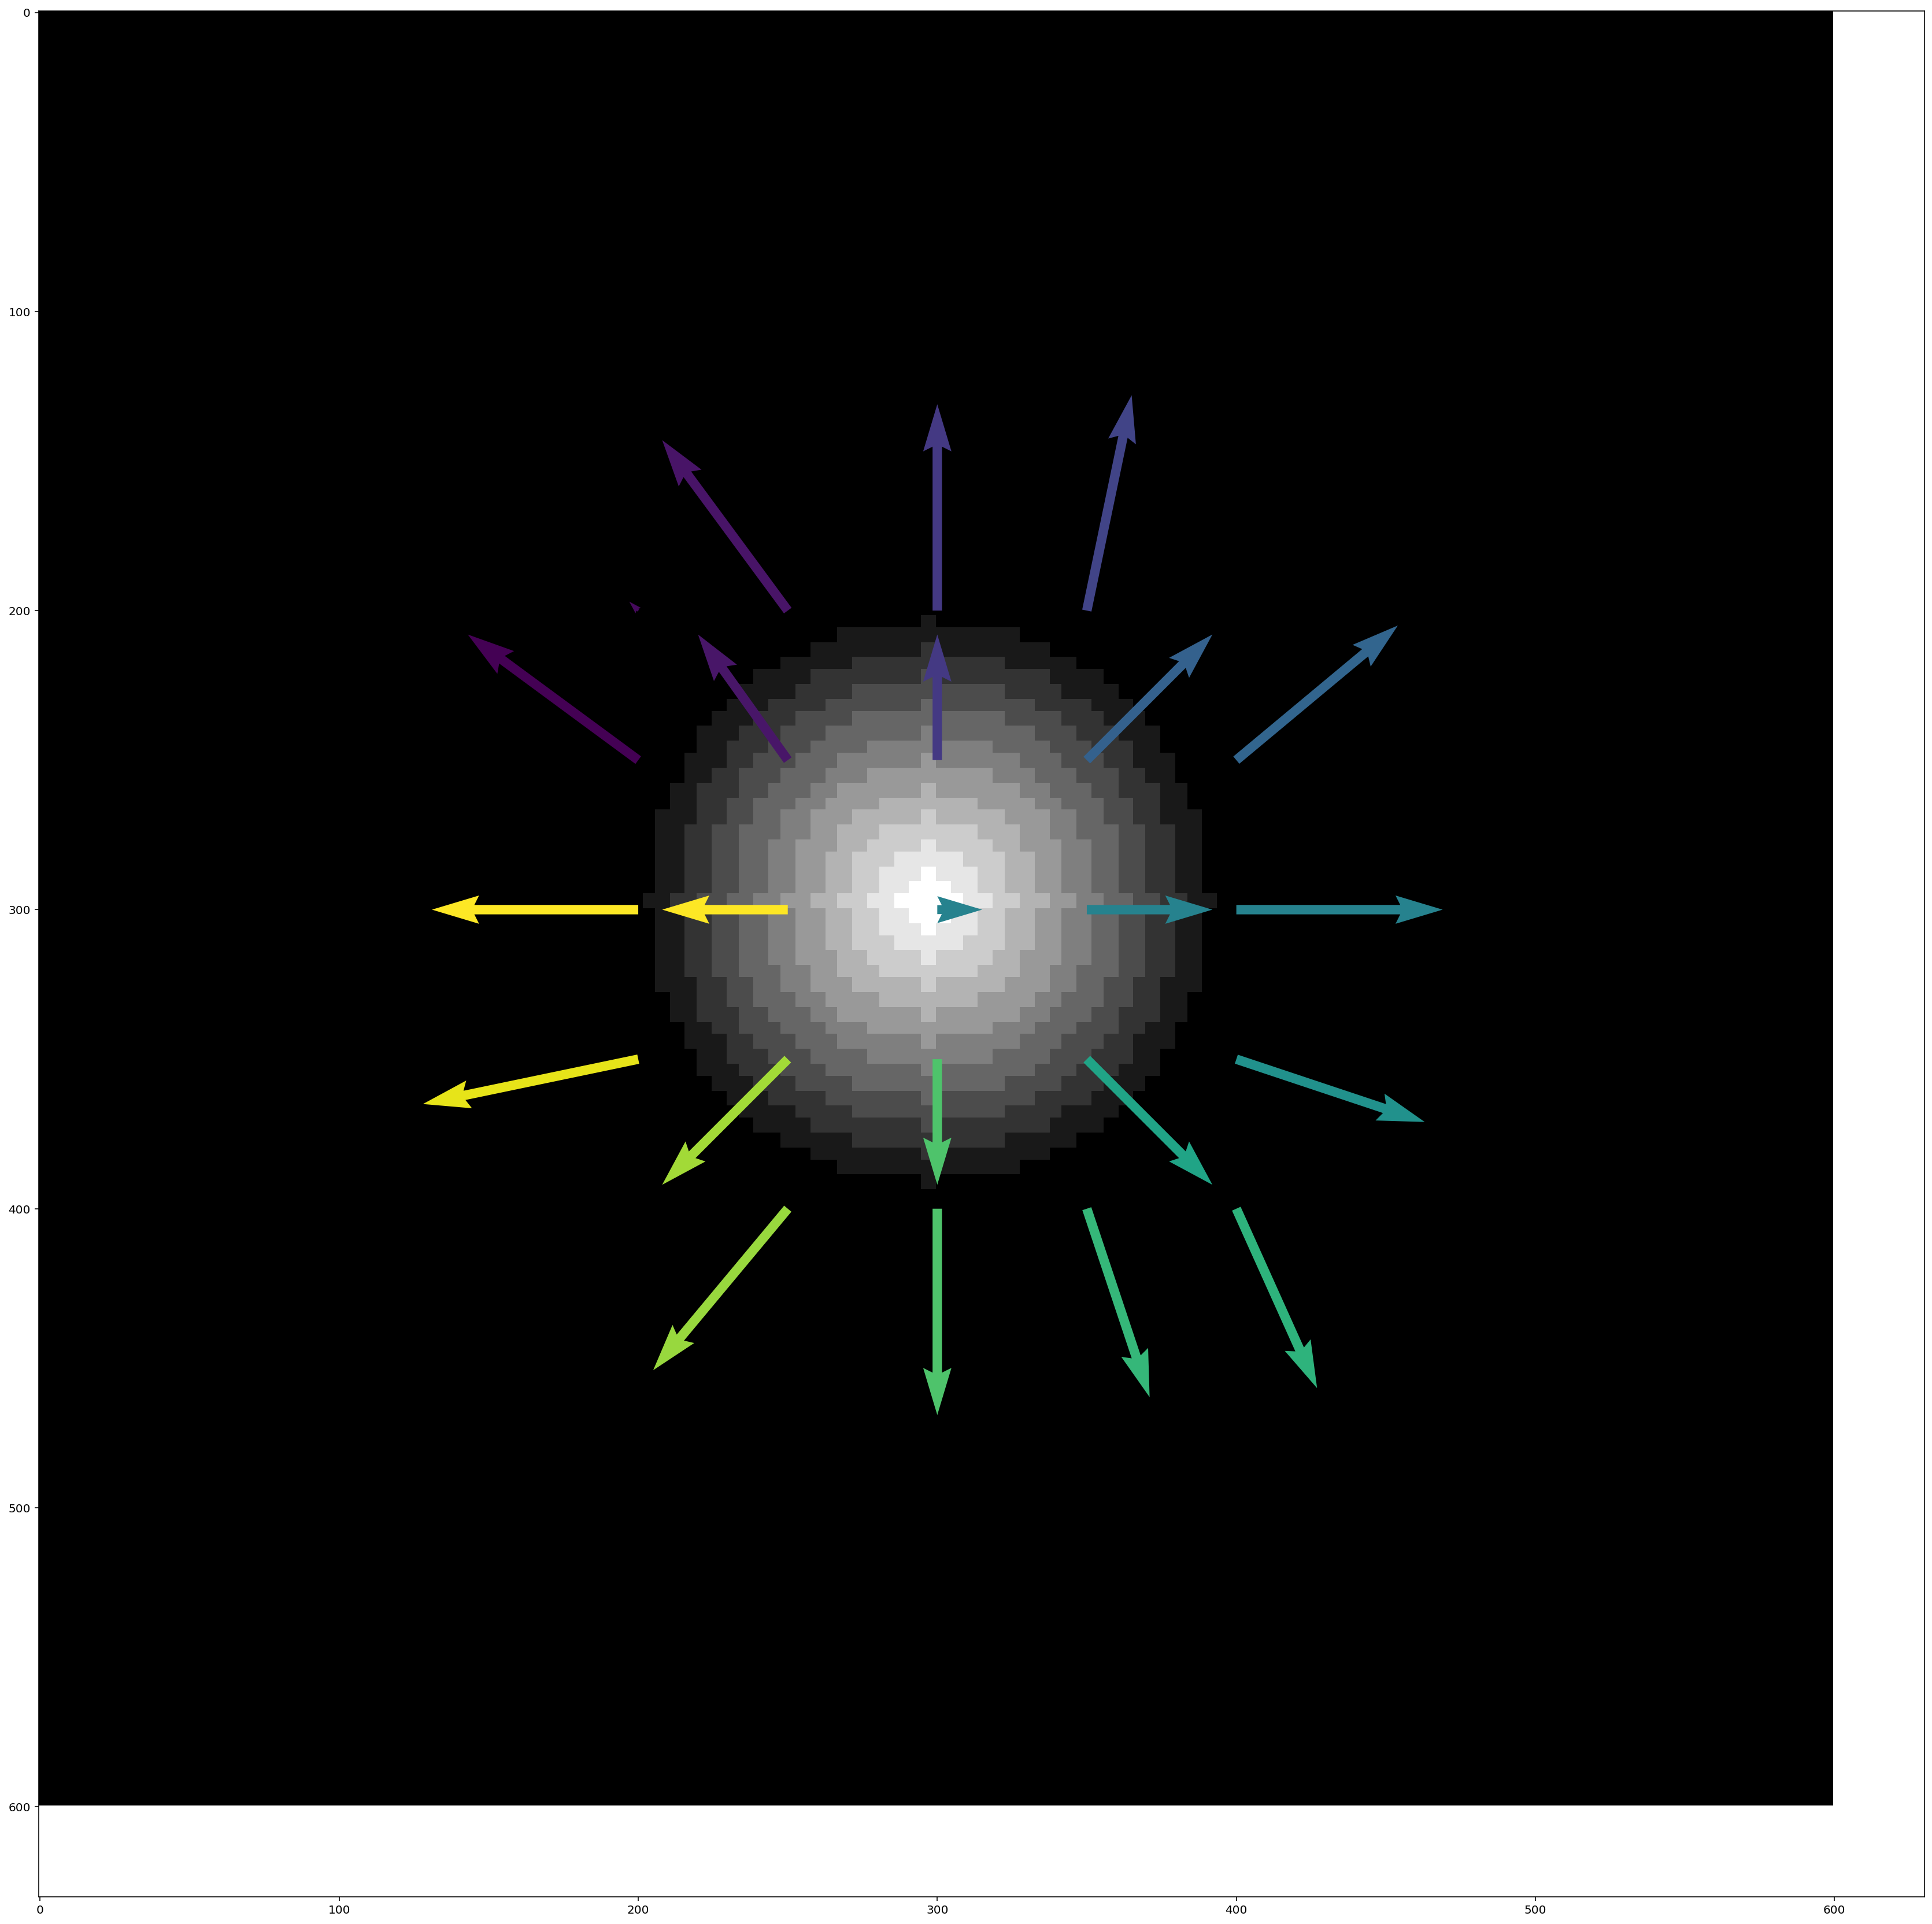

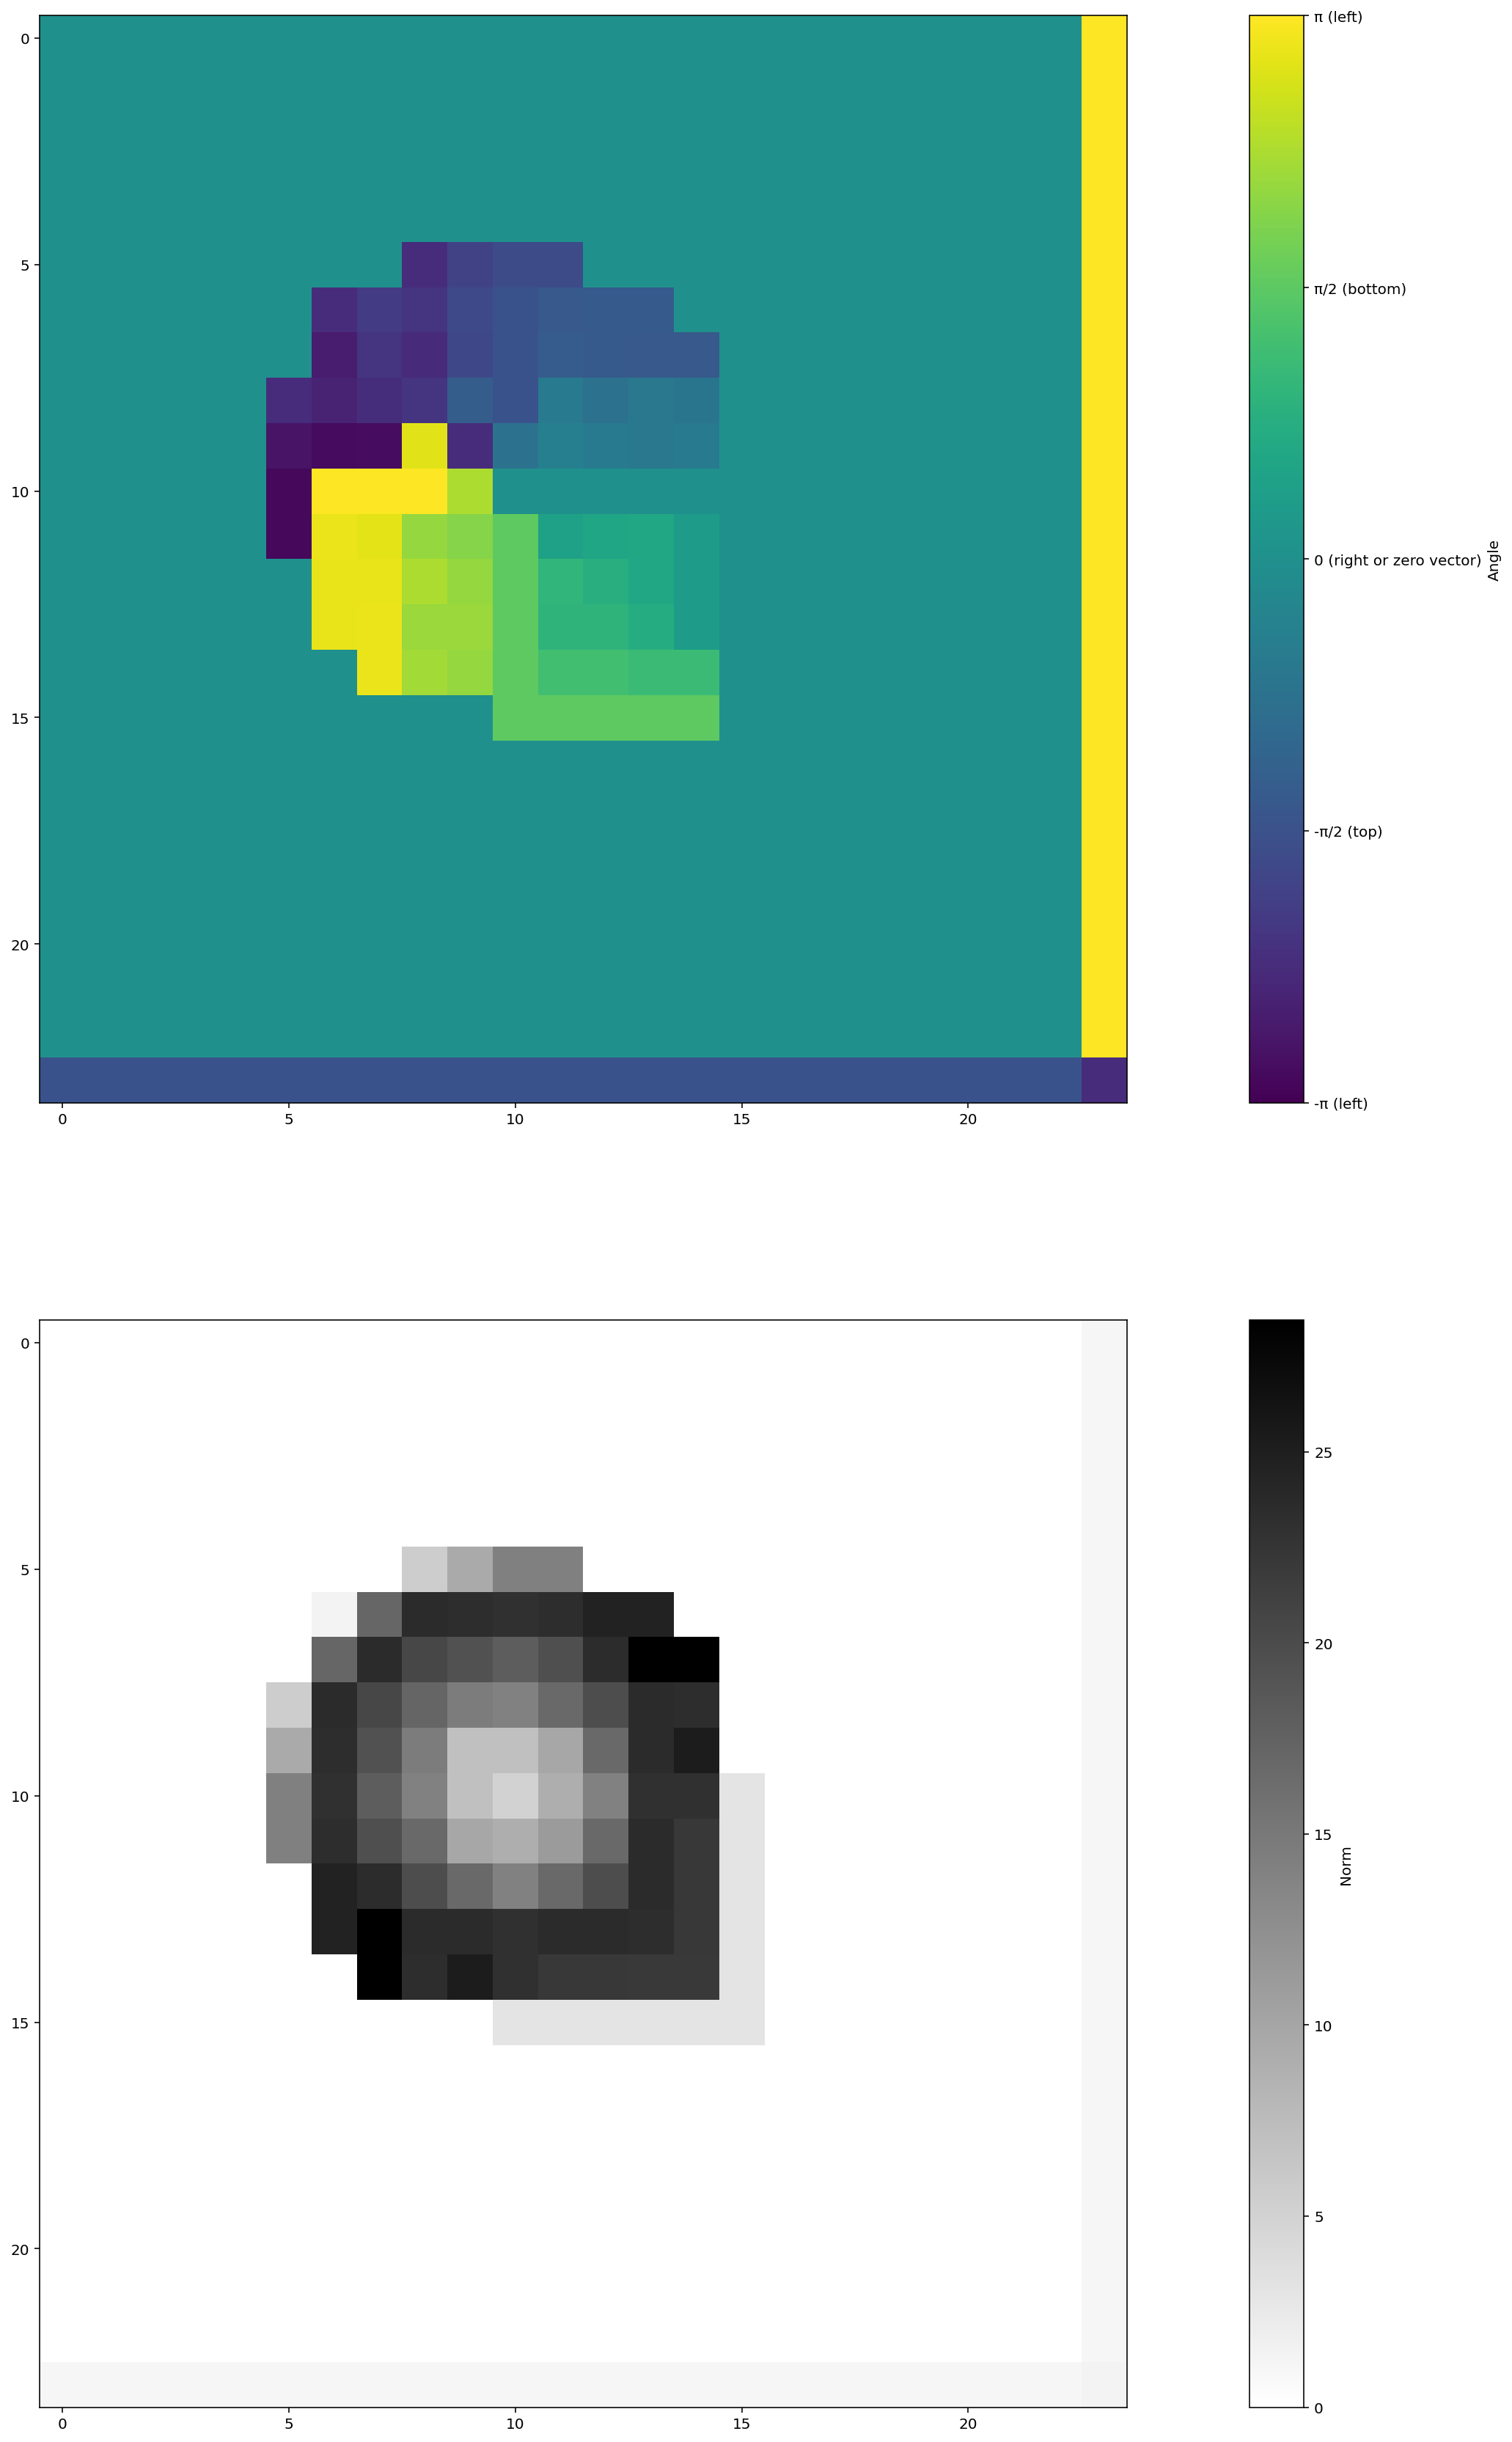

In [19]:
vectors = bma_block_smoothed(images_node_based[0], images_node_based[1], 25, 30, 0.1)
    
# scaled up the vectors by 3 to be able to see them easily
plot_motion_vectors(vectors, images_node_based[0], 25 * 2, 1, 3)
plot_images_motion_vectors(vectors, images_node_based[0].shape)

However, even with the regularization, the movement vectors are still noisy and not very clear. The symmetry is not respected and the vectors are not very smooth.

#### (D.2) Estimation de mouvement Node-based

##### (D.2.A) Sans régularisation

In [20]:
import numpy as np

# Computes the energy function (DFD) between two frames (frame1 and frame2)
# for a specific block using bilinear interpolation with the given displacements.
def compute_dfd(frame1, frame2, block, displacements):
    # Unpack the block coordinates
    xmin, ymin, xmax, ymax = block
    
    # Ensure that the block coordinates are within the frame boundaries
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, frame1.shape[0])
    ymax = min(ymax, frame1.shape[1])

    # Unpack the displacements
    d1, d2, d3, d4 = displacements

    # Create a meshgrid for the block coordinates
    x = np.arange(xmin, xmax)
    y = np.arange(ymin, ymax)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    # Calculate the bilinear interpolation coefficients
    cte = (xmax - xmin) * (ymax - ymin)
    phi1 = ((xmax - xx) * (ymax - yy)) / cte
    phi2 = ((xx - xmin) * (ymax - yy)) / cte
    phi3 = ((xmax - xx) * (yy - ymin)) / cte
    phi4 = ((xx - xmin) * (yy - ymin)) / cte

    # Compute the interpolated displacements
    d = phi1[:, :, None] * d1 + phi2[:, :, None] * d2 \
        + phi3[:, :, None] * d3 + phi4[:, :, None] * d4
    d_int = np.round(d).astype(np.int32)

    # Calculate the new coordinates after applying the displacements
    x_new = np.clip(xx + d_int[..., 0], 0, frame2.shape[0] - 1)
    y_new = np.clip(yy + d_int[..., 1], 0, frame2.shape[1] - 1)

    # Compute the energy function (E_d) as the sum of squared differences
    E_d = np.sum((frame2[x_new, y_new] - frame1[xx, yy]) ** 2)

    return E_d

# Computes the gradient of the energy function with respect to the displacements.
def compute_gradient(frame1, frame2, block, displacements, eps=2):
    gradient = np.zeros_like(displacements)
    for i in range(4):
        for j in range(2):
            e = np.zeros_like(displacements)
            e[i, j] = 1
            grad = compute_dfd(frame1, frame2, block, displacements + e * eps) - \
                compute_dfd(frame1, frame2, block, displacements)
            gradient[i, j] = grad / eps

    return gradient

# Performs gradient descent to minimize the energy function for a given block.
def gradient_descent(frame1, frame2, block, iterations=200, lr=0.1):
    displacements = np.zeros((4, 2), dtype=np.float32)

    for _ in range(iterations):
        gradient = compute_gradient(frame1, frame2, block, displacements)
        displacements -= lr * gradient

    return displacements

# Displaces blocks using gradient descent for each block in the frames.
def displace_blocks(frame1, frame2, block_size=16):
    height, width = frame1.shape
    # Generate a list of block coordinates
    blocks = [(x, y, min(x + block_size, width), min(y + block_size, height))
    for y in range(0, height, block_size)
        for x in range(0, width, block_size)]
    
    displacements_list = []

    # Iterate over all blocks and perform gradient descent for each block
    for i in trange(len(blocks)):
        block = blocks[i]
        displacements = gradient_descent(frame1, frame2, block)
        displacements_list.append(displacements)

    return displacements_list


In [21]:
import matplotlib

def display_blocks_with_displacements(frame, displacements_list, block_size=16):
    """
    Displays the displaced blocks on top of the given frame.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')
    
    height, width = frame.shape
    blocks = [(x, y, min(x + block_size, width), min(y + block_size, height))
              for y in range(0, height, block_size)
              for x in range(0, width, block_size)]
    
    for i, block in enumerate(blocks):
        displacements = displacements_list[i]
        xmin, ymin, xmax, ymax = block
        
        # C D
        # A B
        p_a_x = displacements[0][0]
        p_a_y = displacements[0][1]
        p_b_x = displacements[1][0]
        p_b_y = displacements[1][1]
        p_c_x = displacements[2][0]
        p_c_y = displacements[2][1]
        p_d_x = displacements[3][0]
        p_d_y = displacements[3][1]

        color = np.concatenate((np.random.rand(3), np.array([1])))

        # draw polygon
        polygon = \
            matplotlib.patches.Polygon([(xmin + p_c_x, ymin + p_c_y), # C
                                        (xmax + p_d_x, ymin + p_d_y), # D
                                        (xmax + p_b_x, ymax + p_b_y), # B
                                        (xmin + p_a_x, ymax + p_a_y)], \
                                            closed=True, fill=False, edgecolor=color) # A
        ax.add_patch(polygon)

    plt.show()

def display_displacement_vectors(frame, displacements_list):
    """
    Displays the displacement vectors on top of the given frame.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')
    
    height, width = frame.shape
    blocks = [(x, y, min(x + block_size, width), min(y + block_size, height))
              for y in range(0, height, block_size)
              for x in range(0, width, block_size)]
    
    for i, block in enumerate(blocks):
        displacements = displacements_list[i]

        if np.linalg.norm(displacements) < 0.1:
            continue

        xmin, ymin, xmax, ymax = block

        plt.arrow(xmin + block_size // 2, ymin + block_size // 2, \
                  displacements[0][0], displacements[0][1], color='r', width=1)
    
    plt.show()

  0%|          | 0/225 [00:00<?, ?it/s]

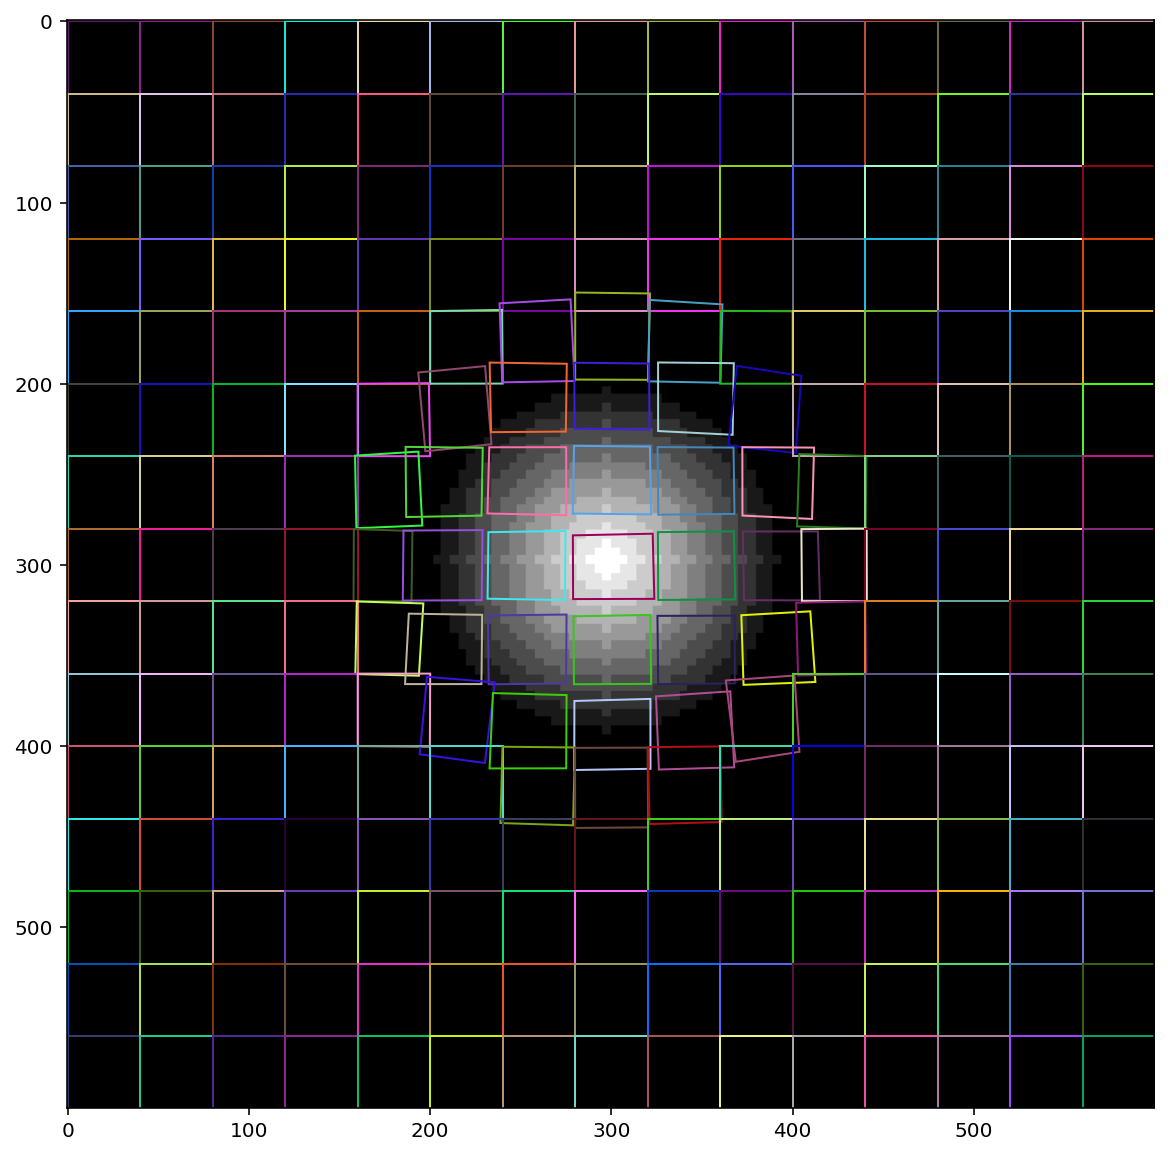

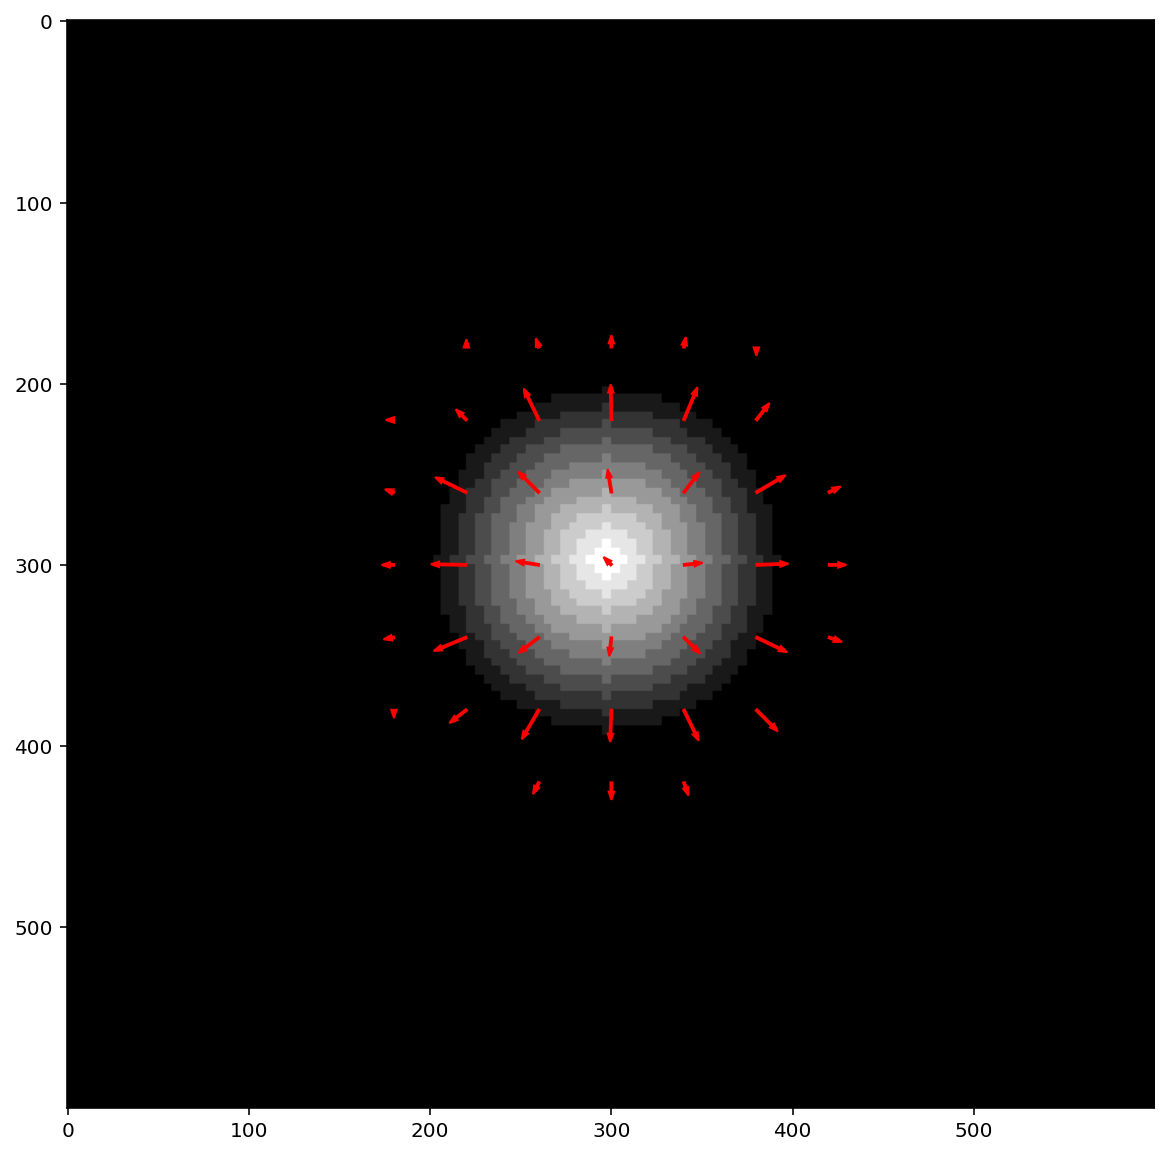

In [22]:
block_size = 600 // 15

frame1 = rgb2gray(images_node_based[0])
frame2 = rgb2gray(images_node_based[1])

displacement_blocks = displace_blocks(frame1, frame2, block_size)

display_blocks_with_displacements(frame1, displacement_blocks, block_size)
display_displacement_vectors(frame1, displacement_blocks)

##### (D.2.B) Avec régularisation

In [23]:
# Computes the energy function (DFD) between two frames (frame1 and frame2)
# for a specific block using bilinear interpolation with the given displacements
# and regularization parameter alpha.
def compute_regularized_dfd(frame1, frame2, block, displacements, alpha=0.1):
    # Unpack the block coordinates
    xmin, ymin, xmax, ymax = block
    
    # Ensure that the block coordinates are within the frame boundaries
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, frame1.shape[0])
    ymax = min(ymax, frame1.shape[1])

    # Unpack the displacements
    d1, d2, d3, d4 = displacements

    # Create a meshgrid for the block coordinates
    x = np.arange(xmin, xmax)
    y = np.arange(ymin, ymax)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    # Compute the bilinear interpolation coefficients
    cte = (xmax - xmin) * (ymax - ymin)
    phi1 = ((xmax - xx) * (ymax - yy)) / cte
    phi2 = ((xx - xmin) * (ymax - yy)) / cte
    phi3 = ((xmax - xx) * (yy - ymin)) / cte
    phi4 = ((xx - xmin) * (yy - ymin)) / cte

    # Compute the interpolated displacements
    d = phi1[:, :, None] * d1 + phi2[:, :, None] * d2 \
        + phi3[:, :, None] * d3 + phi4[:, :, None] * d4
    d_int = np.round(d).astype(np.int32)

    # Compute the new coordinates after applying the displacements
    x_new = np.clip(xx + d_int[..., 0], 0, frame2.shape[0] - 1)
    y_new = np.clip(yy + d_int[..., 1], 0, frame2.shape[1] - 1)

    # Compute the DFD energy with regularization term
    E_d = np.sum((frame2[x_new, y_new] - frame1[xx, yy]) ** 2) + alpha * np.sum(np.abs(displacements) ** 2)

    return E_d

# Computes the gradient of the energy function with respect to the displacements.
def compute_gradient_regularized(frame1, frame2, block, displacements, alpha=0.1, eps=2):
    gradient = np.zeros_like(displacements)
    for i in range(4):
        for j in range(2):
            e = np.zeros_like(displacements)
            e[i, j] = 1
            grad = \
                compute_regularized_dfd(frame1, frame2, block, displacements + e * eps, alpha) - \
                compute_regularized_dfd(frame1, frame2, block, displacements, alpha)
            gradient[i, j] = grad / eps

    return gradient

# Performs gradient descent to minimize the energy function for a given block.
def gradient_descent_regularized(frame1, frame2, block, alpha=0.1, iterations=200, lr=0.1):
    displacements = np.zeros((4, 2), dtype=np.float32)

    for _ in range(iterations):
        gradient = compute_gradient_regularized(frame1, frame2, block, displacements, alpha)
        displacements -= lr * gradient

    return displacements

# Displaces blocks using gradient descent for each block in the frames.
def displace_blocks_regularized(frame1, frame2, block_size=16, alpha=0.1):
    height, width = frame1.shape
    blocks = [(x, y, min(x + block_size, width), min(y + block_size, height))
              for y in range(0, height, block_size)
              for x in range(0, width, block_size)]

    displacements_list = []

    for i in trange(len(blocks)):
        block = blocks[i]
        displacements = gradient_descent_regularized(frame1, frame2, block, alpha)
        displacements_list.append(displacements)

    return displacements_list

  0%|          | 0/225 [00:00<?, ?it/s]

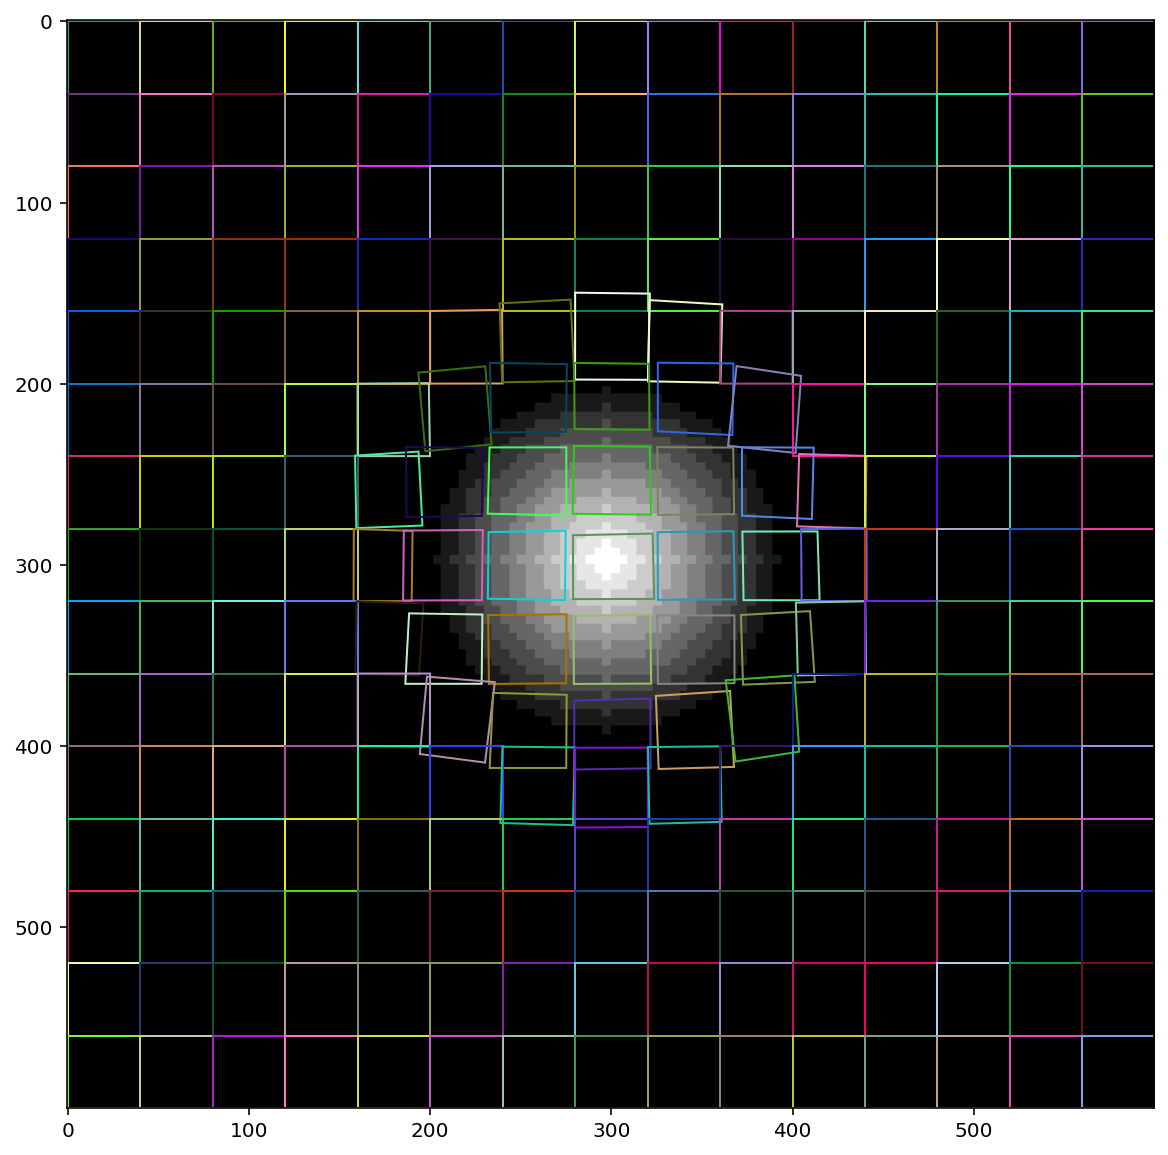

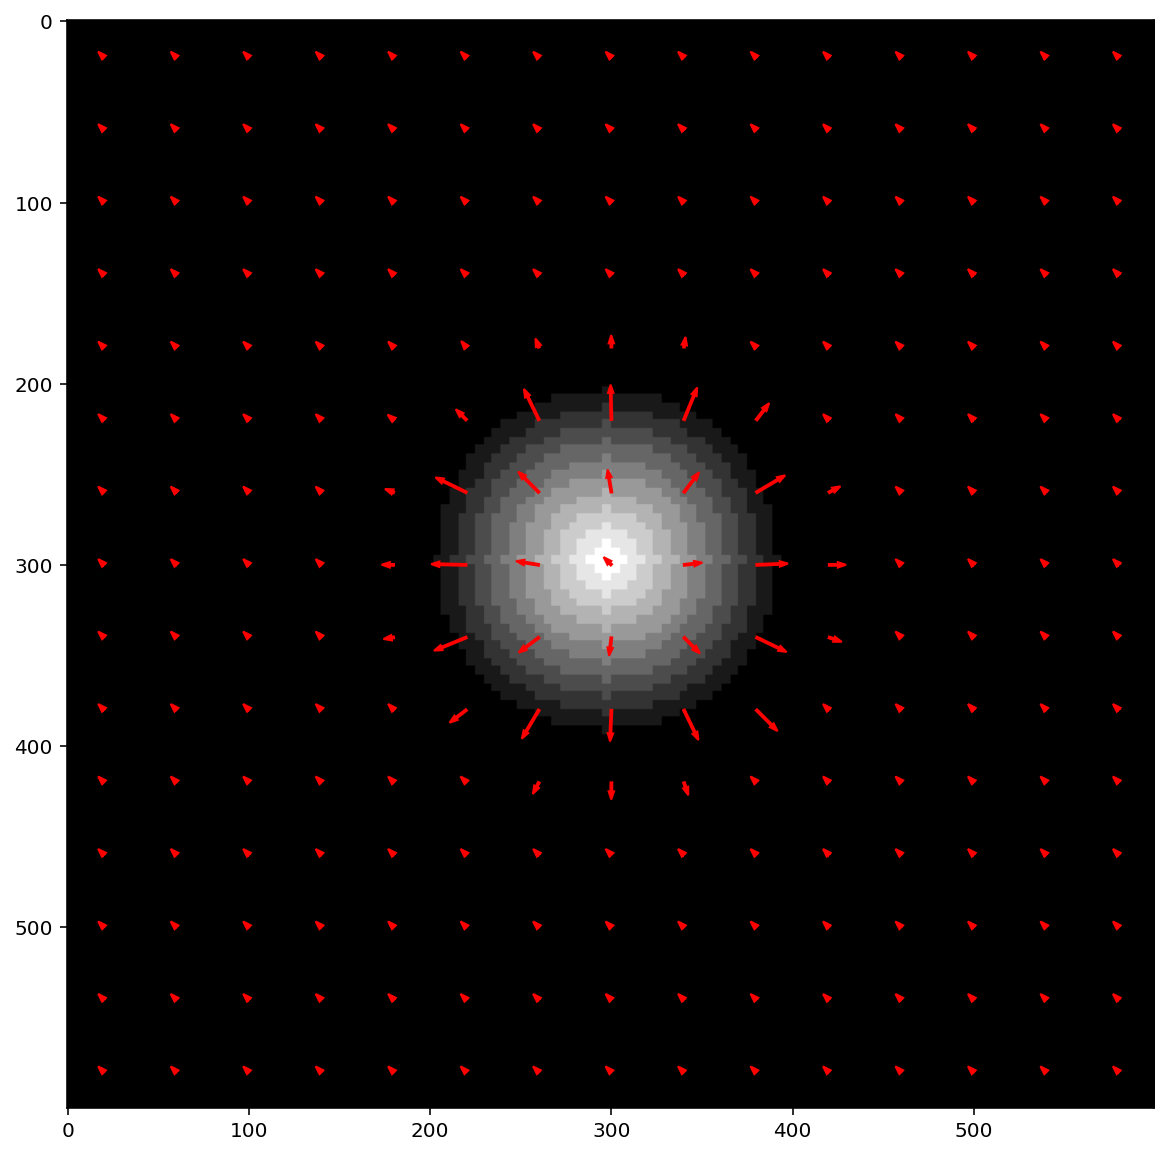

In [24]:
block_size = 600 // 15

frame1 = rgb2gray(images_node_based[0])
frame2 = rgb2gray(images_node_based[1])

displacement_blocks = displace_blocks_regularized(frame1, frame2, block_size, 0.001)

display_blocks_with_displacements(frame1, displacement_blocks, block_size)
display_displacement_vectors(frame1, displacement_blocks)

##### (D.2.C) Qu’observez vous par rapport a la méthode par blocs ?

Il est beaucoup plus facile d'obtenir un mouvement cohérent et régulier avec la méthode node-based, en effet celle-ci est beaucoup moins sensible aux changements de luminosité et aux changements de couleurs, de plus elle est beaucoup plus précise et permet de mieux exprimer le mouvement réél.

#### (D.3) Estimation de mouvement Mesh-based avec une descente de gradients (approximé par les différences finies)

##### (D.3.A) Sans régularisation

In [25]:
# Function to compute the sum of squared differences between two frames given a node and its displacements
def compute_dfd(frame1, frame2, node, displacements, nx, ny):
    i, j = node
    width, height = frame1.shape

    # Calculate the region in the frame corresponding to the node
    xmin = int(i * width / nx)
    ymin = int(j * height / ny)
    xmax = int((i + 1) * width / nx)
    ymax = int((j + 1) * height / ny)

    # Ensure the region coordinates are within the frame boundaries
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, frame1.shape[0])
    ymax = min(ymax, frame1.shape[1])

    d = displacements

    x = np.arange(xmin, xmax)
    y = np.arange(ymin, ymax)

    # Create a meshgrid for the block coordinates
    xx, yy = np.meshgrid(x, y, indexing='ij')

    d_int = np.round(d).astype(np.int32)

    # Compute the new coordinates after applying the displacements
    x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
    y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)

    # Calculate the sum of squared differences
    E_d = np.sum((frame2[x_new, y_new] - frame1[xx, yy]) ** 2)

    return E_d

# Function to compute the gradient of the sum of squared differences
def compute_gradient(frame1, frame2, node, displacements, eps, nx, ny):
    gradient = np.zeros_like(displacements)
    for i in range(2):
        e = np.zeros_like(displacements)
        e[i] = 1
        grad = compute_dfd(frame1, frame2, node, displacements + e * eps, nx, ny) - \
            compute_dfd(frame1, frame2, node, displacements, nx, ny)
        gradient[i] = grad / eps

    return gradient

# Function to perform gradient descent on the mesh
def gradient_descent_mesh(frame1, frame2, iterations=200, lr=0.1, nx=4, ny=4):
    displacements = np.zeros((nx, ny, 2), dtype=np.float32)

    for _ in range(iterations):
        for i in range(nx):
            for j in range(ny):
                node = (i, j)
                gradient = \
                    compute_gradient(frame1, frame2, node, displacements[i, j], 2, nx, ny)
                displacements[i, j] -= lr * gradient

    return displacements

# Function to displace the mesh using the calculated displacements
def displace_mesh(frame1, frame2, nx=4, ny=4):
    height, width = frame1.shape
    mesh_grid = np.zeros((height, width), dtype=frame1.dtype)

    displacements = gradient_descent_mesh(frame1, frame2, nx=nx, ny=ny)

    for i in trange(nx):
        for j in range(ny):
            displacements_node = displacements[i, j]

            # Calculate the corresponding region in the frame
            xmin = int(i * width / nx)
            ymin = int(j * height / ny)
            xmax = int((i + 1) * width / nx)
            ymax = int((j + 1) * height / ny)

            x = np.arange(xmin, xmax)
            y = np.arange(ymin, ymax)
            xx, yy = np.meshgrid(x, y, indexing='ij')

            d_int = np.round(displacements_node).astype(np.int32)
            x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
            y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)
            mesh_grid[xmin:xmax, ymin:ymax] = frame1[x_new, y_new]

    return displacements

In [26]:
def display_mesh(frame, displacements):
    """
    Display the mesh with the displacements
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')

    height, width = frame.shape
    nx, ny = displacements.shape[:2]

    for i in range(nx):
        for j in range(ny):
            dx, dy = displacements[i, j]
            x = int(i * width / nx + width / (2 * nx))
            y = int(j * height / ny + height / (2 * ny))

            x_new = x + dx
            y_new = y + dy

            # Draw horizontal lines
            if j < ny - 1:
                dx_right, dy_right = displacements[i, j + 1]
                x_right = int(i * width / nx + width / (2 * nx))
                y_right = int((j + 1) * height / ny + height / (2 * ny))
                x_right_new = x_right + dx_right
                y_right_new = y_right + dy_right

                ax.plot([x_new, x_right_new], [y_new, y_right_new])

            # Draw vertical lines
            if i < nx - 1:
                dx_down, dy_down = displacements[i + 1, j]
                x_down = int((i + 1) * width / nx + width / (2 * nx))
                y_down = int(j * height / ny + height / (2 * ny))
                x_down_new = x_down + dx_down
                y_down_new = y_down + dy_down

                ax.plot([x_new, x_down_new], [y_new, y_down_new])

    plt.show()

def display_displacement_vectors(frame, displacements):
    """
    Display the displacement vectors on the frame
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')

    height, width = frame.shape
    nx, ny = displacements.shape[:2]

    for i in range(nx):
        for j in range(ny):
            dx, dy = displacements[i, j]
            x = int(i * width / nx + width / (2 * nx))
            y = int(j * height / ny + height / (2 * ny))

            if np.linalg.norm([dx, dy]) < 1:
                continue

            ax.arrow(x, y, dx, dy, color='red')

    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

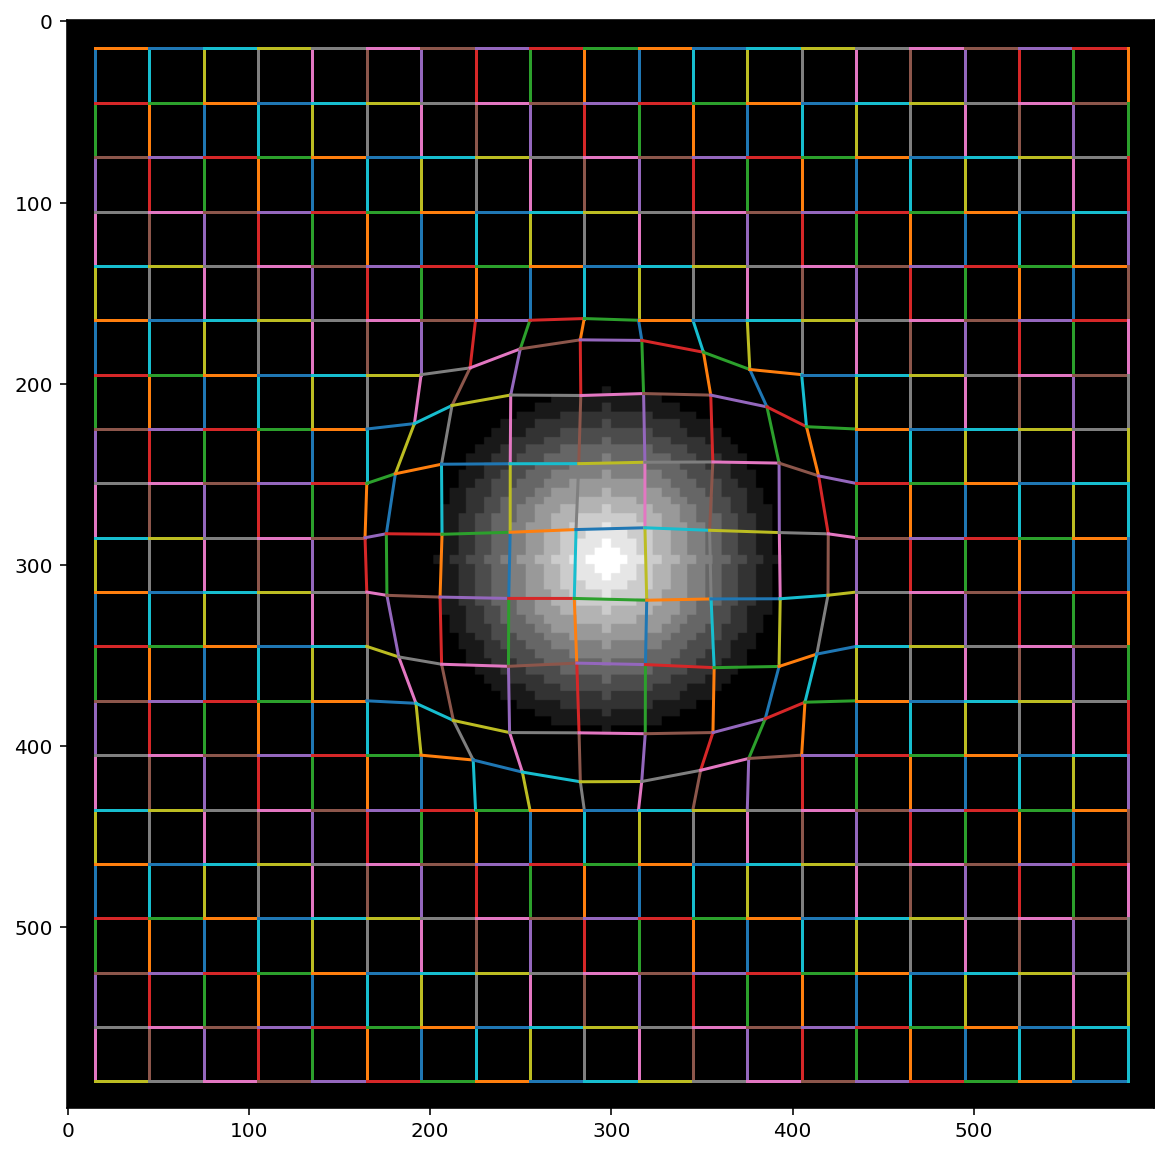

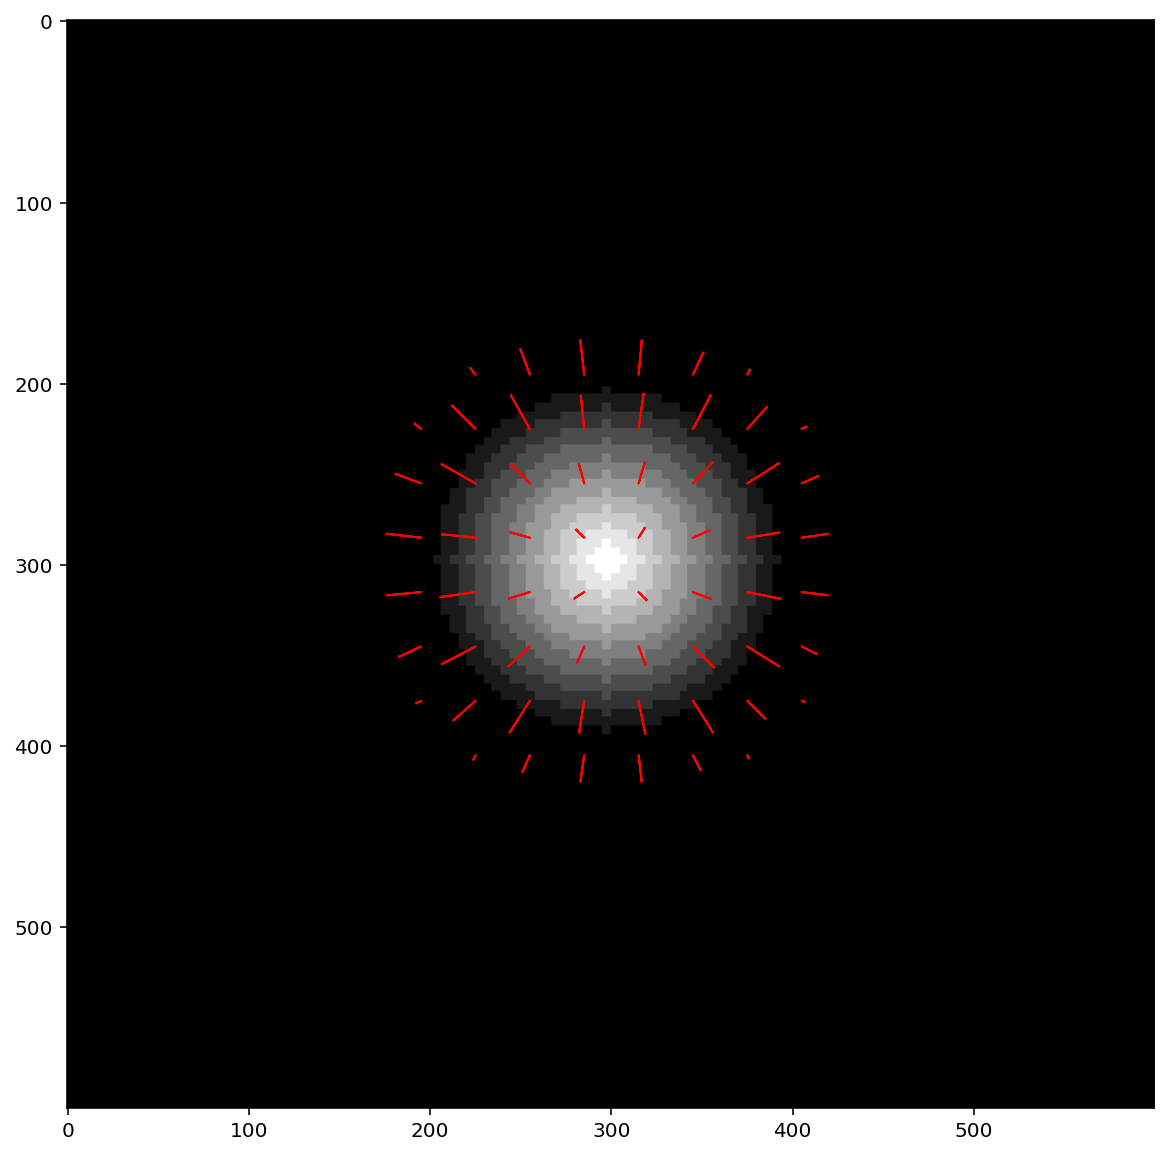

In [27]:
block_div = 20
nx=block_div
ny=block_div

frame1 = rgb2gray(images_node_based[0])
frame2 = rgb2gray(images_node_based[1])

displacement_mesh = displace_mesh(frame1, frame2, nx, ny)
display_mesh(frame1, displacement_mesh)
display_displacement_vectors(frame1, displacement_mesh)

##### (D.3.B) Avec régularisation

  0%|          | 0/20 [00:00<?, ?it/s]

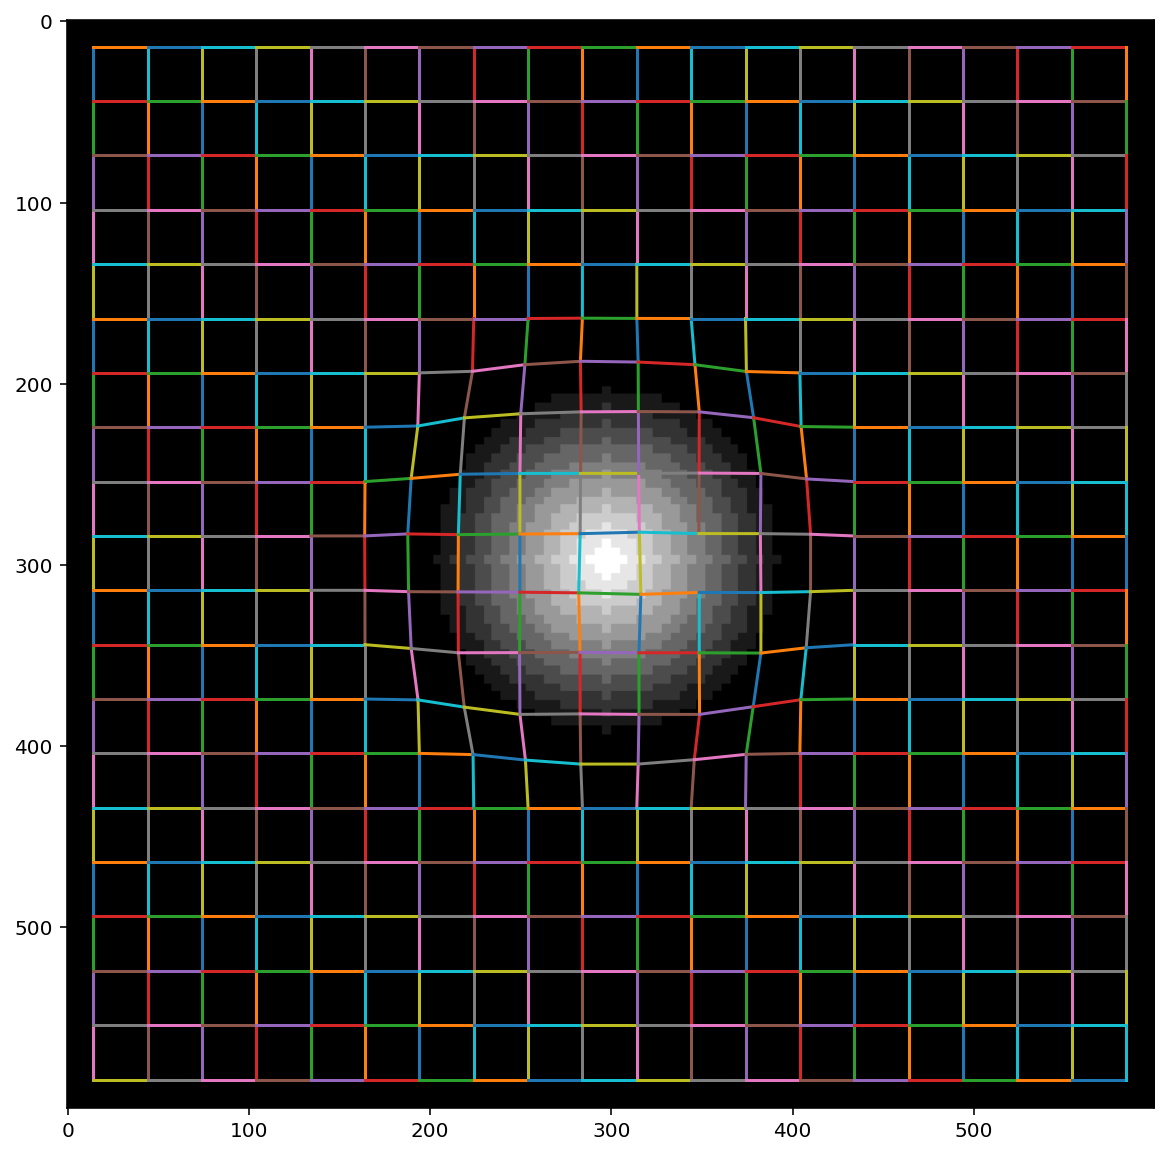

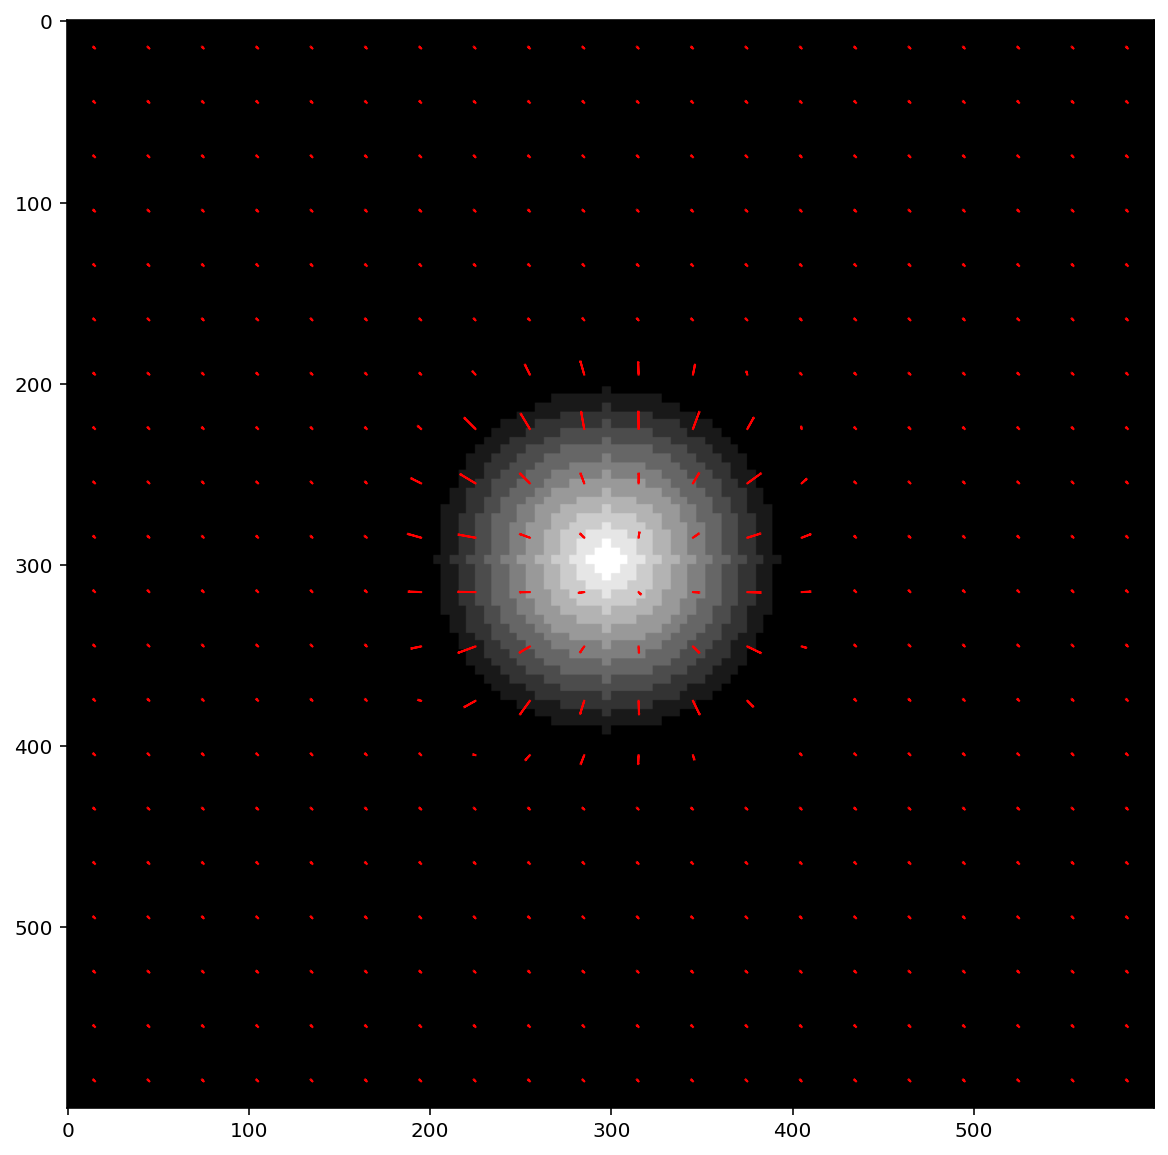

In [28]:
# Function to compute the sum of squared differences between two frames given a node and its displacements
# with a regularization term
def compute_dfd_regularized(frame1, frame2, node, displacements, nx, ny, alpha=0.1):
    i, j = node
    height, width = frame1.shape

    # Calculate the region in the frame corresponding to the node
    xmin = int(i * width / nx)
    ymin = int(j * height / ny)
    xmax = int((i + 1) * width / nx)
    ymax = int((j + 1) * height / ny)

    # Ensure the region coordinates are within the frame boundaries
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, frame1.shape[0])
    ymax = min(ymax, frame1.shape[1])

    d = displacements

    x = np.arange(xmin, xmax)
    y = np.arange(ymin, ymax)

    # Create a meshgrid for the block coordinates
    xx, yy = np.meshgrid(x, y, indexing='ij')

    d_int = np.round(d).astype(np.int32)

    # Compute the new coordinates after applying the displacements
    x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
    y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)

    # Calculate the sum of squared differences
    E_d = np.sum((frame2[x_new, y_new] - frame1[xx, yy]) ** 2)

    # Compute and add the regularization term
    R_d = alpha * np.sum(d ** 2)

    return E_d + R_d

# Function to compute the gradient of the sum of squared differences
def compute_gradient_regularized(frame1, frame2, node, displacements, eps, nx, ny):
    gradient = np.zeros_like(displacements)
    for i in range(2):
        e = np.zeros_like(displacements)
        e[i] = 1
        grad = compute_dfd_regularized(frame1, frame2, node, displacements + e * eps, nx, ny) - \
            compute_dfd_regularized(frame1, frame2, node, displacements, nx, ny)
        gradient[i] = grad / eps

    return gradient

# Function to perform gradient descent on the mesh
def gradient_descent_mesh_regularized(frame1, frame2, iterations=200, lr=0.1, nx=4, ny=4):
    displacements = np.zeros((nx, ny, 2), dtype=np.float32)

    for _ in range(iterations):
        for i in range(nx):
            for j in range(ny):
                node = (i, j)
                gradient = compute_gradient_regularized(frame1, frame2, node, displacements[i, j], 2, nx, ny)
                displacements[i, j] -= lr * gradient

    return displacements

# Function to displace the mesh using the calculated displacements
def displace_mesh_regularized(frame1, frame2, nx=4, ny=4):
    height, width = frame1.shape
    mesh_grid = np.zeros((height, width), dtype=frame1.dtype)

    displacements = gradient_descent_mesh_regularized(frame1, frame2, nx=nx, ny=ny)

    for i in trange(nx):
        for j in range(ny):
            displacements_node = displacements[i, j]

            # Calculate the corresponding region in the frame
            xmin = int(i * width / nx)
            ymin = int(j * height / ny)
            xmax = int((i + 1) * width / nx)
            ymax = int((j + 1) * height / ny)

            x = np.arange(xmin, xmax)
            y = np.arange(ymin, ymax)
            xx, yy = np.meshgrid(x, y, indexing='ij')

            d_int = np.round(displacements_node).astype(np.int32)
            x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
            y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)
            mesh_grid[xmin:xmax, ymin:ymax] = frame1[x_new, y_new]

    return displacements

block_div = 20
nx=block_div
ny=block_div

frame1 = rgb2gray(images_node_based[0])
frame2 = rgb2gray(images_node_based[1])

displacement_mesh = displace_mesh_regularized(frame1, frame2, nx, ny)
display_mesh(frame1, displacement_mesh)
display_displacement_vectors(frame1, displacement_mesh)

##### (D.3.C) Pourquoi utilise-t-on une descente de gradients ?

Nous utilisons une descente de gradient car c'est la méthode la plus adaptée pour trouver le minimum d'une fonction, or ici nous cherchons à minimiser la "fonction d'erreur" (qui est en réalité une DFD) entre les deux images, c'est donc une des méthodes les plus adaptées.

##### (D.3.D) Vos estimations de champs de vecteurs sont elles plus ou moins régulières que le cas avec blocs ?

Elles sont plus régulières car elles sont moins sensibles aux changements de luminosité et de couleurs, notamment grâce à la régularisation et interpolation.